In [1]:
%matplotlib inline
import os
import sys
from glob import glob

import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import copy

import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import gpflow
import tensorflow as tf

code_dir = '/cluster/home/kheuto01/code/zero-inflated-gp/'
sys.path.append(code_dir)

from onoffgpf import OnOffSVGP, OnOffLikelihood

/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("q

In [2]:
data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/'
result_dir = os.path.join(data_dir, 'results')
mass_shapefile = os.path.join(data_dir,'shapefiles','MA_2021')



new_tract_shapefile = os.path.join(data_dir,'shapefiles','new_trimmed_tract',
                                   'cb_2020_tract')

In [3]:
new_tract_shapefile


'/cluster/tufts/hugheslab/datasets/NSF_OD/shapefiles/new_trimmed_tract/cb_2020_tract'

In [4]:
mass_gdf = gpd.read_file(new_tract_shapefile)


In [5]:
mass_gdf

STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID     NAME  \
0         25      001  012700  1400000US25001012700  25001012700      127   
1         25      001  013400  1400000US25001013400  25001013400      134   
2         25      009  250600  1400000US25009250600  25009250600     2506   
3         25      009  205100  1400000US25009205100  25009205100     2051   
4         25      009  206400  1400000US25009206400  25009206400     2064   
...      ...      ...     ...                   ...          ...      ...   
1609      25      027  750200  1400000US25027750200  25027750200     7502   
1610      25      005  653102  1400000US25005653102  25005653102  6531.02   
1611      25      005  645101  1400000US25005645101  25005645101  6451.01   
1612      25      021  423101  1400000US25021423101  25021423101  4231.01   
1613      25      023  505201  1400000US25023505201  25023505201  5052.01   

                  NAMELSAD STUSPS         NAMELSADCO     STATE_NAME LSAD  \
0         Census Tract 127     MA  Barnstable County  Massachusetts   CT   
1         Census Tract 134     MA  Barnstable County  Massachusetts   CT   
2        Census Tract 2506     MA       Essex County  Massachusetts   CT   
3        Census Tract 2051     MA       Essex County  Massachusetts   CT   
4        Census Tract 2064     MA       Essex County  Massachusetts   CT   
...                    ...    ...                ...            ...  ...   
1609     Census Tract 7502     MA   Worcester County  Massachusetts   CT   
1610  Census Tract 6531.02     MA     Bristol County  Massachusetts   CT   
1611  Census Tract 6451.01     MA     Bristol County  Massachusetts   CT   
1612  Census Tract 4231.01     MA     Norfolk County  Massachusetts   CT   
1613  Census Tract 5052.01     MA    Plymouth County  Massachusetts   CT   

         ALAND    AWATER                                           geometry  
0      9606912    902420  POLYGON ((-70.37554 41.65239, -70.37266 41.652...  
1     21892831    518183  POLYGON ((-70.49465 41.74300, -70.48889 41.745...  
2       659027         0  POLYGON ((-71.17242 42.72166, -71.17115 42.723...  
3      1826304    139897  POLYGON ((-70.95086 42.49498, -70.94992 42.494...  
4       851338         0  POLYGON ((-70.93904 42.47729, -70.93595 42.481...  
...        ...       ...                                                ...  
1609  30525350   1284678  POLYGON ((-71.70476 42.10384, -71.69756 42.113...  
1610  45259774    457124  POLYGON ((-71.07667 41.68747, -71.06663 41.685...  
1611   5582701   4995814  POLYGON ((-71.23766 41.73313, -71.22298 41.733...  
1612   6763810   1144939  POLYGON ((-70.82338 42.23476, -70.80944 42.242...  
1613   9307721  11716129  POLYGON ((-70.77886 42.18419, -70.77221 42.184...  

[1614 rows x 14 columns]

In [6]:


svi_file = os.path.join(result_dir,'svi_qtr')
svi_gdf = gpd.read_file(svi_file)
svi_gdf = svi_gdf.rename(columns={'INTPTLAT':'lat', 'INTPTLON':'lon', 'GEOID':'grid_squar'})
# Make lat and lon floats
svi_gdf.loc[:, 'lat'] = svi_gdf.lat.astype(float)
svi_gdf.loc[:, 'lon'] = svi_gdf.lon.astype(float)
deaths_gdf = svi_gdf



In [7]:
missing_squares = [square for square in deaths_gdf['grid_squar'].unique() if square not in mass_gdf['GEOID'].unique()]

<AxesSubplot:>

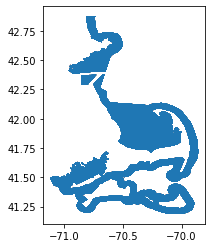

In [8]:
deaths_gdf[deaths_gdf['grid_squar'].isin(missing_squares)].plot()

In [9]:
just_grid = deaths_gdf.loc[(deaths_gdf['year']==2000)&(deaths_gdf['quarter']==4), ['grid_squar','geometry', 'lat', 'lon']]


In [10]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    https://stackoverflow.com/a/4913653/1748679
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [11]:
just_grid

grid_squar                                           geometry  \
4860  25017333300  POLYGON ((-71.16139 42.47071, -71.16136 42.471...   
4861  25017333400  POLYGON ((-71.14690 42.48077, -71.14673 42.480...   
4862  25017333502  POLYGON ((-71.15960 42.48482, -71.15954 42.484...   
4863  25017354500  POLYGON ((-71.13077 42.38261, -71.13070 42.382...   
4864  25017354700  POLYGON ((-71.12901 42.39007, -71.12768 42.389...   
...           ...                                                ...   
6475  25009208302  POLYGON ((-71.01723 42.48901, -71.01705 42.489...   
6476  25009212101  POLYGON ((-71.05565 42.62288, -71.05509 42.625...   
6477  25009208401  POLYGON ((-71.04695 42.48796, -71.04672 42.488...   
6478  25009208402  POLYGON ((-71.05389 42.47878, -71.05373 42.479...   
6479  25009212102  POLYGON ((-71.05935 42.60633, -71.05916 42.607...   

            lat        lon  
4860  42.470764 -71.152055  
4861  42.484548 -71.132032  
4862  42.485040 -71.146119  
4863  42.384745 -71.125040  
4864  42.389581 -71.122629  
...         ...        ...  
6475  42.485038 -71.004081  
6476  42.613694 -71.005231  
6477  42.487612 -71.030763  
6478  42.466251 -71.035971  
6479  42.600718 -71.030823  

[1620 rows x 4 columns]

In [12]:
# Calculate each squares neighbors
neighbors = {}
for _, row in just_grid.iterrows():
    just_grid.loc[:,'haversine'] = just_grid.apply(lambda x: haversine(row['lon'], row['lat'],
                                                                         x['lon'], x['lat']),
                                                  axis=1)
    matching_neighbors = just_grid[just_grid['haversine']<8]['grid_squar'].values
    neighbors[row['grid_squar']]=matching_neighbors

In [13]:
tracts = deaths_gdf['grid_squar'].unique()
min_year = deaths_gdf.year.min()
max_year = deaths_gdf.year.max()

In [14]:
deaths_gdf = deaths_gdf.set_index(['grid_squar','year','quarter']).sort_index()

In [15]:
deaths_gdf.loc[idx[:,:,:],'self_t-1'] = deaths_gdf.loc[idx[:,:,:],'deaths'].shift(1, fill_value=0)

In [16]:
for tract in tracts:
     deaths_gdf.loc[idx[tract,:,:],'neighbor_t-1']= \
        deaths_gdf.loc[idx[neighbors[tract],:,:],'self_t-1'].groupby(level=['year', 'quarter']).mean().shift(1, fill_value=0).values

In [17]:
deaths_gdf.loc[idx[tract,2011,:],:]

STATEFP COUNTYFP TRACTCE     NAME  \
grid_squar  year quarter                                     
25009212102 2011 1            25      009  212102  2121.02   
                 2            25      009  212102  2121.02   
                 3            25      009  212102  2121.02   
                 4            25      009  212102  2121.02   

                                      NAMELSAD  MTFCC FUNCSTAT     ALAND  \
grid_squar  year quarter                                                   
25009212102 2011 1        Census Tract 2121.02  G5020        S  14256626   
                 2        Census Tract 2121.02  G5020        S  14256626   
                 3        Census Tract 2121.02  G5020        S  14256626   
                 4        Census Tract 2121.02  G5020        S  14256626   

                           AWATER        lat  ...  theme_3_pc  theme_4_pc  \
grid_squar  year quarter                      ...                           
25009212102 2011 1        2121499  42.600718  ...        0.44       0.736   
                 2        2121499  42.600718  ...        0.44       0.736   
                 3        2121499  42.600718  ...        0.44       0.736   
                 4        2121499  42.600718  ...        0.44       0.736   

                          svi_pctile  FIPS  ROUNDED_TR  ROUNDED__1  TRACTCE_y  \
grid_squar  year quarter                                                        
25009212102 2011 1            0.5171  None      212100      212100       None   
                 2            0.5171  None      212100      212100       None   
                 3            0.5171  None      212100      212100       None   
                 4            0.5171  None      212100      212100       None   

                                                                   geometry  \
grid_squar  year quarter                                                      
25009212102 2011 1        POLYGON ((-71.05935 42.60633, -71.05916 42.607...   
                 2        POLYGON ((-71.05935 42.60633, -71.05916 42.607...   
                 3        POLYGON ((-71.05935 42.60633, -71.05916 42.607...   
                 4        POLYGON ((-71.05935 42.60633, -71.05916 42.607...   

                         self_t-1 neighbor_t-1  
grid_squar  year quarter                        
25009212102 2011 1            0.0          0.0  
                 2            0.0          0.0  
                 3            0.0          0.0  
                 4            0.0          0.0  

[4 rows x 25 columns]

In [18]:
timestep = 0

for year in range(min_year, max_year+1):
    for quarter in range(1, 5):
        deaths_gdf.loc[idx[:,year, quarter], 'timestep'] = timestep
        timestep+=1

In [19]:
deaths_gdf.loc[idx[:,2012,:],:]

STATEFP COUNTYFP TRACTCE     NAME  \
grid_squar  year quarter                                     
25001010100 2012 1            25      001   10100      101   
                 2            25      001   10100      101   
                 3            25      001   10100      101   
                 4            25      001   10100      101   
25001010206 2012 1            25      001   10206   102.06   
...                          ...      ...     ...      ...   
25027761401 2012 4            25      027  761401  7614.01   
25027761402 2012 1            25      027  761402  7614.02   
                 2            25      027  761402  7614.02   
                 3            25      027  761402  7614.02   
                 4            25      027  761402  7614.02   

                                      NAMELSAD  MTFCC FUNCSTAT     ALAND  \
grid_squar  year quarter                                                   
25001010100 2012 1            Census Tract 101  G5020        S  25046216   
                 2            Census Tract 101  G5020        S  25046216   
                 3            Census Tract 101  G5020        S  25046216   
                 4            Census Tract 101  G5020        S  25046216   
25001010206 2012 1         Census Tract 102.06  G5020        S  51240906   
...                                        ...    ...      ...       ...   
25027761401 2012 4        Census Tract 7614.01  G5020        S  42913109   
25027761402 2012 1        Census Tract 7614.02  G5020        S  25568170   
                 2        Census Tract 7614.02  G5020        S  25568170   
                 3        Census Tract 7614.02  G5020        S  25568170   
                 4        Census Tract 7614.02  G5020        S  25568170   

                            AWATER        lat  ...  theme_4_pc  svi_pctile  \
grid_squar  year quarter                       ...                           
25001010100 2012 1        12765872  42.059829  ...       0.720      0.4528   
                 2        12765872  42.059829  ...       0.720      0.4528   
                 3        12765872  42.059829  ...       0.720      0.4528   
                 4        12765872  42.059829  ...       0.720      0.4528   
25001010206 2012 1        18828934  41.922636  ...       0.225      0.0602   
...                            ...        ...  ...         ...         ...   
25027761401 2012 4         1640138  42.489753  ...       0.304      0.2291   
25027761402 2012 1          209089  42.531342  ...       0.304      0.2291   
                 2          209089  42.531342  ...       0.304      0.2291   
                 3          209089  42.531342  ...       0.304      0.2291   
                 4          209089  42.531342  ...       0.304      0.2291   

                                 FIPS  ROUNDED_TR  ROUNDED__1  TRACTCE_y  \
grid_squar  year quarter                                                   
25001010100 2012 1        25001010100        None        None       None   
                 2        25001010100        None        None       None   
                 3        25001010100        None        None       None   
                 4        25001010100        None        None       None   
25001010206 2012 1        25001010206        None        None       None   
...                               ...         ...         ...        ...   
25027761401 2012 4               None      761400      761400       None   
25027761402 2012 1               None      761400      761400       None   
                 2               None      761400      761400       None   
                 3               None      761400      761400       None   
                 4               None      761400      761400       None   

                                                                   geometry  \
grid_squar  year quarter                                                      
25001010100 2012 1        POLYGON ((-70.25001 42.06410, -70.24959 4

In [20]:
deaths_gdf_with_autoregressive = deaths_gdf.reset_index()

In [21]:
deaths_gdf_with_autoregressive

grid_squar  year  quarter STATEFP COUNTYFP TRACTCE     NAME  \
0       25001010100  2000        1      25      001   10100      101   
1       25001010100  2000        2      25      001   10100      101   
2       25001010100  2000        3      25      001   10100      101   
3       25001010100  2000        4      25      001   10100      101   
4       25001010100  2001        1      25      001   10100      101   
...             ...   ...      ...     ...      ...     ...      ...   
142555  25027761402  2020        4      25      027  761402  7614.02   
142556  25027761402  2021        1      25      027  761402  7614.02   
142557  25027761402  2021        2      25      027  761402  7614.02   
142558  25027761402  2021        3      25      027  761402  7614.02   
142559  25027761402  2021        4      25      027  761402  7614.02   

                    NAMELSAD  MTFCC FUNCSTAT  ...  theme_4_pc  svi_pctile  \
0           Census Tract 101  G5020        S  ...      0.6872      0.6230   
1           Census Tract 101  G5020        S  ...      0.6872      0.6230   
2           Census Tract 101  G5020        S  ...      0.6872      0.6230   
3           Census Tract 101  G5020        S  ...      0.6872      0.6230   
4           Census Tract 101  G5020        S  ...      0.6872      0.6230   
...                      ...    ...      ...  ...         ...         ...   
142555  Census Tract 7614.02  G5020        S  ...      0.1598      0.2237   
142556  Census Tract 7614.02  G5020        S  ...      0.1598      0.2237   
142557  Census Tract 7614.02  G5020        S  ...      0.1598      0.2237   
142558  Census Tract 7614.02  G5020        S  ...      0.1598      0.2237   
142559  Census Tract 7614.02  G5020        S  ...      0.1598      0.2237   

               FIPS  ROUNDED_TR  ROUNDED__1  TRACTCE_y  \
0       25001010100        None        None       None   
1       25001010100        None        None       None   
2       25001010100        None        None       None   
3       25001010100        None        None       None   
4       25001010100        None        None       None   
...             ...         ...         ...        ...   
142555         None      761400      761400       None   
142556         None      761400      761400       None   
142557         None      761400      761400       None   
142558         None      761400      761400       None   
142559         None      761400      761400       None   

                                                 geometry  self_t-1  \
0       POLYGON ((-70.25001 42.06410, -70.24959 42.065...       0.0   
1       POLYGON ((-70.25001 42.06410, -70.24959 42.065...       0.0   
2       POLYGON ((-70.25001 42.06410, -70.24959 42.065...       0.0   
3       POLYGON ((-70.25001 42.06410, -70.24959 42.065...       0.0   
4       POLYGON ((-70.25001 42.06410, -70.24959 42.065...       0.0   
...                                                   ...       ...   
142555  POLYGON ((-71.63921 42.53096, -71.63906 42.531...       0.0   
142556  POLYGON ((-71.63921 42.53096, -71.63906 42.531...       0.0   
142557  POLYGON ((-71.63921 42.53096, -71.63906 42.531...       1.0   
142558  POLYGON ((-71.63921 42.53096, -71.63906 42.531...       0.0   
142559  POLYGON ((-71.63921 42.53096, -71.63906 42.531...       0.0   

        neighbor_t-1  timestep  
0              0.000       0.0  
1              0.000       1.0  
2              0.000       2.0  
3              0.000       3.0  
4              0.000       4.0  
...              ...       ...  
142555         0.250      83.0  
142556         0.250      84.0  
142557         0.000      85.0  
142558         0.375      86.0  
142559         0.375      87.0  

[142560 rows x 29 columns]

In [22]:
train_x_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar',  'timestep', 'deaths']]
train_x_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar', 'timestep', 'deaths']]

x_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','timestep', 'deaths']]
x_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
y_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar', 'timestep', 'deaths']]

x_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','timestep', 'deaths']]


In [23]:
spatial_kernel = gpflow.kernels.RBF(2, active_dims=[0,1])
temporal_kernel = gpflow.kernels.RBF(1, active_dims=[2])
demo_kernel =  gpflow.kernels.RBF(7,active_dims=[3,4,5,6,7,8,9])
gaussian_kernel = spatial_kernel + temporal_kernel + demo_kernel

f_kernel = copy.deepcopy(gaussian_kernel)
g_kernel = copy.deepcopy(gaussian_kernel)


In [24]:
likelihood = OnOffLikelihood()

In [25]:
random = np.random.default_rng(seed=1)

In [26]:
M = 200
N = len(train_x_through_2018)
Z = random.choice(train_x_through_2018[['lat','lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values, size=M, replace=False)

Zf = copy.deepcopy(Z)
Zg = copy.deepcopy(Z)

train_dataset = tf.data.Dataset.from_tensor_slices((train_x_through_2018.loc[:, ['lat','lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']], 
                                                   train_y_through_2018.loc[:,'deaths'].values.reshape(-1,1))).repeat().shuffle(N)


In [27]:
class LoggerCB(object):
    def __init__(self):
        self.logs = []
    def cb(self, result):
        print(result)
        self.logs.append(result['fun'])
logger_cb = LoggerCB()

In [23]:
m = OnOffSVGP(train_x_through_2018.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc',
                                           'theme_3_pc', 'theme_4_pc', 'svi_pctile',
                                           'neighbor_t-1', 'self_t-1']].values,
              train_y_through_2018.loc[:,'deaths'].values.reshape(-1,1)
              ,kernf=f_kernel,
              kerng=g_kernel
              ,likelihood = OnOffLikelihood()
              ,Zf = Zf,
              Zg = Zg
             )

# fix the model noise term
m.likelihood.variance = 0.01
m.likelihood.variance.fixed = False

In [50]:
train_x_through_2018.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc',
                                           'theme_3_pc', 'theme_4_pc', 'svi_pctile',
                                           'neighbor_t-1', 'self_t-1']].values

array([[ 42.0598291, -70.2004073,   0.       , ...,   0.623    ,
          0.       ,   0.       ],
       [ 42.0598291, -70.2004073,   1.       , ...,   0.623    ,
          0.       ,   0.       ],
       [ 42.0598291, -70.2004073,   2.       , ...,   0.623    ,
          0.       ,   0.       ],
       ...,
       [ 42.5313417, -71.5927511,  73.       , ...,   0.1229   ,
          0.25     ,   0.       ],
       [ 42.5313417, -71.5927511,  74.       , ...,   0.1229   ,
          0.       ,   0.       ],
       [ 42.5313417, -71.5927511,  75.       , ...,   0.1229   ,
          0.125    ,   1.       ]])

In [74]:
%%time
opt_result= m.optimize(maxiter = 200) #,method= tf.train.AdamOptimizer(learning_rate = 0.01)
print(m.compute_log_likelihood())
opt_result

-55346.13810928944
CPU times: user 56min 45s, sys: 22min 40s, total: 1h 19min 25s
Wall time: 40min 13s


      fun: 55346.13810928945
 hess_inv: <4813x4813 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.05560826,  0.03335286, -0.04420543, ..., -0.54635153,
       -0.21253859, -0.38487209])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 218
      nit: 200
     njev: 218
   status: 1
  success: False
        x: array([ 40.82279859, -70.89026979,  56.23345841, ...,  -0.89033864,
         0.27274592,   0.54196997])

In [75]:
m.mean_function(m.sorted_params)

TypeError: Failed to convert object of type <class 'list'> to Tensor. Contents: [<gpflow.param.Param object at 0x7fbde0435080>, <gpflow.param.Param object at 0x7fbde0435588>, <gpflow.kernels.Add object at 0x7fbde0432470>, <gpflow.kernels.Add object at 0x7fbde0434278>, <onoffgpf.OnOffLikelihood.OnOffLikelihood object at 0x7fbde0434630>, <gpflow.mean_functions.Zero object at 0x7fbde0432588>, <gpflow.param.Param object at 0x7fbde0435518>, <gpflow.param.Param object at 0x7fbde0435470>, <gpflow.param.Param object at 0x7fbde04354a8>, <gpflow.param.Param object at 0x7fbde0435400>]. Consider casting elements to a supported type.

In [32]:
logger_cb

In [31]:
sg_2019 = m.predict_onoffgp(x_just_2019q1.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values)
sg_2019 = sg_2019[0]

In [32]:
sg_2019.min()

-0.03863501663441614

In [33]:
sg_2019[-1]

array([0.16639467])

In [34]:
pred_2019_df = pd.Series(sg_2019.squeeze(), index=x_just_2019q1.grid_squar)


In [35]:
y_just_2019q1

grid_squar  timestep  deaths
76      25001010100      76.0     0.0
164     25001010206      76.0     0.0
252     25001010208      76.0     0.0
340     25001010304      76.0     0.0
428     25001010306      76.0     0.0
...             ...       ...     ...
142196  25027761100      76.0     0.0
142284  25027761200      76.0     0.0
142372  25027761300      76.0     1.0
142460  25027761401      76.0     0.0
142548  25027761402      76.0     0.0

[1620 rows x 3 columns]

In [36]:
sg_MAE_2019 = mean_absolute_error(y_just_2019q1.deaths, pred_2019_df)

sg_MLAE_2019 = mean_log_absolute_error(y_just_2019q1.deaths, pred_2019_df)

sg_top_10_2019 = top_X(y_just_2019q1.set_index('grid_squar')['deaths'], pred_2019_df, 10)
sg_top_50_2019 = top_X(y_just_2019q1.set_index('grid_squar')['deaths'], pred_2019_df, 50)
sg_top_100_2019 = top_X(y_just_2019q1.set_index('grid_squar')['deaths'], pred_2019_df, 100)

NameError: name 'mean_log_absolute_error' is not defined

In [38]:
sg_MAE_2019

0.38190415392137683

In [39]:
sg_top_10_2019

(25.0, 0.21875, 25.0, 0.21875)

In [40]:
sg_top_100_2019

(102.0, 0.4, 102.0, 0.4000000000000001)

In [28]:
def mean_log_absolute_error(y_true, y_pred):
    
    min_val = abs(min(min(y_true), min(y_pred))) + 1

    return np.average(np.abs(np.log(y_pred.values+min_val) -
                             np.log(y_true.values+min_val)), axis=0)
def top_X(y_true, y_pred, X=10):
    
    top_X_predicted = y_pred.sort_values(ascending=False)[:X]
    top_X_true = y_true.sort_values(ascending=False)[:X]
    
    undisputed_top_predicted = top_X_predicted[top_X_predicted>top_X_predicted.min()]
    num_tied_spots = X - len(undisputed_top_predicted)
    undisputed_top_true = top_X_true[top_X_true > top_X_true.min()]
    num_true_ties = X - len(undisputed_top_true)
    
    tied_top_predicted = top_X_predicted[top_X_predicted==top_X_predicted.min()]
    tied_top_true = top_X_true[top_X_true==top_X_true.min()]
    
    error_in_top_true_ties = np.abs(tied_top_true-y_pred[tied_top_true.index]).sort_values(ascending=True)
    error_in_top_pred_ties = np.abs(y_true[tied_top_predicted.index]-tied_top_predicted).sort_values(ascending=True)
    top_true_tied_geoids = error_in_top_true_ties[:num_true_ties].index
    top_pred_tied_geoids = error_in_top_pred_ties[:num_tied_spots].index

    best_possible_top_true_geoids = pd.Index.union(undisputed_top_true.index, top_true_tied_geoids)
    best_possible_top_pred_geoids = pd.Index.union(undisputed_top_predicted.index, top_pred_tied_geoids)
    
    # True values of GEOIDS with highest actual deaths. If ties, finds tied locations that match preds best
    best_possible_true = y_true[best_possible_top_true_geoids]
    best_possible_pred = y_true[best_possible_top_pred_geoids]

    assert(len(best_possible_true)==X)
    assert(len(best_possible_pred)==X)
    
    best_possible_absolute = np.abs(best_possible_true.sum() - best_possible_pred.sum())
    best_possible_ratio = np.abs(best_possible_pred).sum()/np.abs(best_possible_true).sum()
    
    
    bootstrapped_tied_indices = np.random.choice(tied_top_predicted.index, (1000, num_tied_spots))
    bootstrapped_all_indices =  [pd.Index.union(undisputed_top_predicted.index,
                                                bootstrap_index) for bootstrap_index in bootstrapped_tied_indices]
    
    bootstrapped_absolute = np.mean([np.abs(top_X_true.sum() - y_true[indices].sum()) 
                                     for indices in bootstrapped_all_indices])
    bootstrapped_ratio = np.mean([np.abs(y_true[indices]).sum()/np.abs(top_X_true).sum()
                                  for indices in bootstrapped_all_indices])
    
    return best_possible_absolute, best_possible_ratio, bootstrapped_absolute, bootstrapped_ratio

In [41]:
print(sg_MAE_2019 )

print(sg_MLAE_2019 )

print(sg_top_10_2019 [0])
print(sg_top_50_2019[0])
print(sg_top_100_2019 [0])
print(sg_top_10_2019 [1])
print(sg_top_50_2019[1])
print(sg_top_100_2019 [1])


0.38190415392137683
0.2653638502108166
25.0
79.0
102.0
0.21875
0.29464285714285715
0.4


In [37]:
deaths_and_preds = y_just_2019.merge(pred_2019_df.rename('pred_deaths'),left_on='grid_squar', right_index=True)

baseline_2019_df =deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2018) &
                                                 (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','deaths']]
    
baseline_2019_df = pd.Series(baseline_2019_df['deaths'].values, index=baseline_2019_df['grid_squar'])
deaths_and_baseline = y_just_2019.merge(baseline_2019_df.rename('pred_deaths'),left_on='grid_squar', right_index=True)

In [38]:
deaths_and_preds_annual = deaths_and_preds.groupby('grid_squar').sum()
deaths_and_preds_annual

timestep  deaths  pred_deaths
grid_squar                                
25001010100     310.0     1.0     0.795529
25001010206     310.0     1.0     0.709041
25001010208     310.0     0.0     0.615901
25001010304     310.0     1.0     0.657047
25001010306     310.0     0.0     0.697376
...               ...     ...          ...
25027761100     310.0     0.0     0.787882
25027761200     310.0     1.0     0.688999
25027761300     310.0     1.0     0.681620
25027761401     310.0     0.0     0.647756
25027761402     310.0     0.0     0.665579

[1620 rows x 3 columns]

In [39]:
deaths_and_preds.loc[:,'residuals'] = deaths_and_preds.deaths-deaths_and_preds.pred_deaths
deaths_and_baseline.loc[:,'residuals'] = deaths_and_baseline.deaths-deaths_and_baseline.pred_deaths

In [40]:
residual_gdf = just_grid.merge(deaths_and_preds_annual, on='grid_squar')
residual_gdf = residual_gdf[~residual_gdf['grid_squar'].isin(missing_squares)]
residual_baseline_gdf = just_grid.merge(deaths_and_baseline, on='grid_squar')

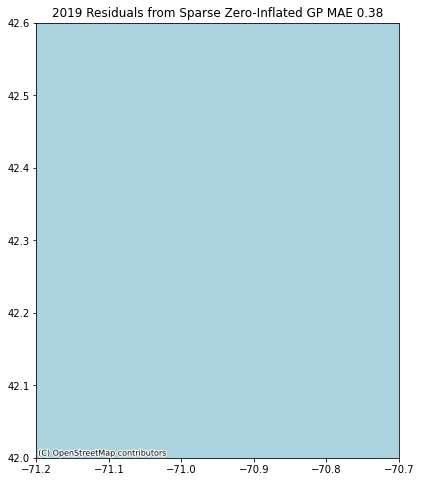

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
#residual_gdf.plot(column='residuals', cmap='RdBu_r',ax=ax, 
#                  legend=True, vmax=4, vmin=-4, alpha=0.05)
plt.title(f'2019 Residuals from Sparse Zero-Inflated GP MAE {sg_MAE_2019:.2f}')
plt.xlim([-71.2, -70.7])
plt.ylim([42, 42.6])
ctx.add_basemap(ax, zoom=5,source=ctx.providers.OpenStreetMap.Mapnik);

In [49]:
lat_space = 0.1
lon_space = (71.2-70.93)/2

boston_lat = 42.3
boston_lon = -(71.2+70.93)/2


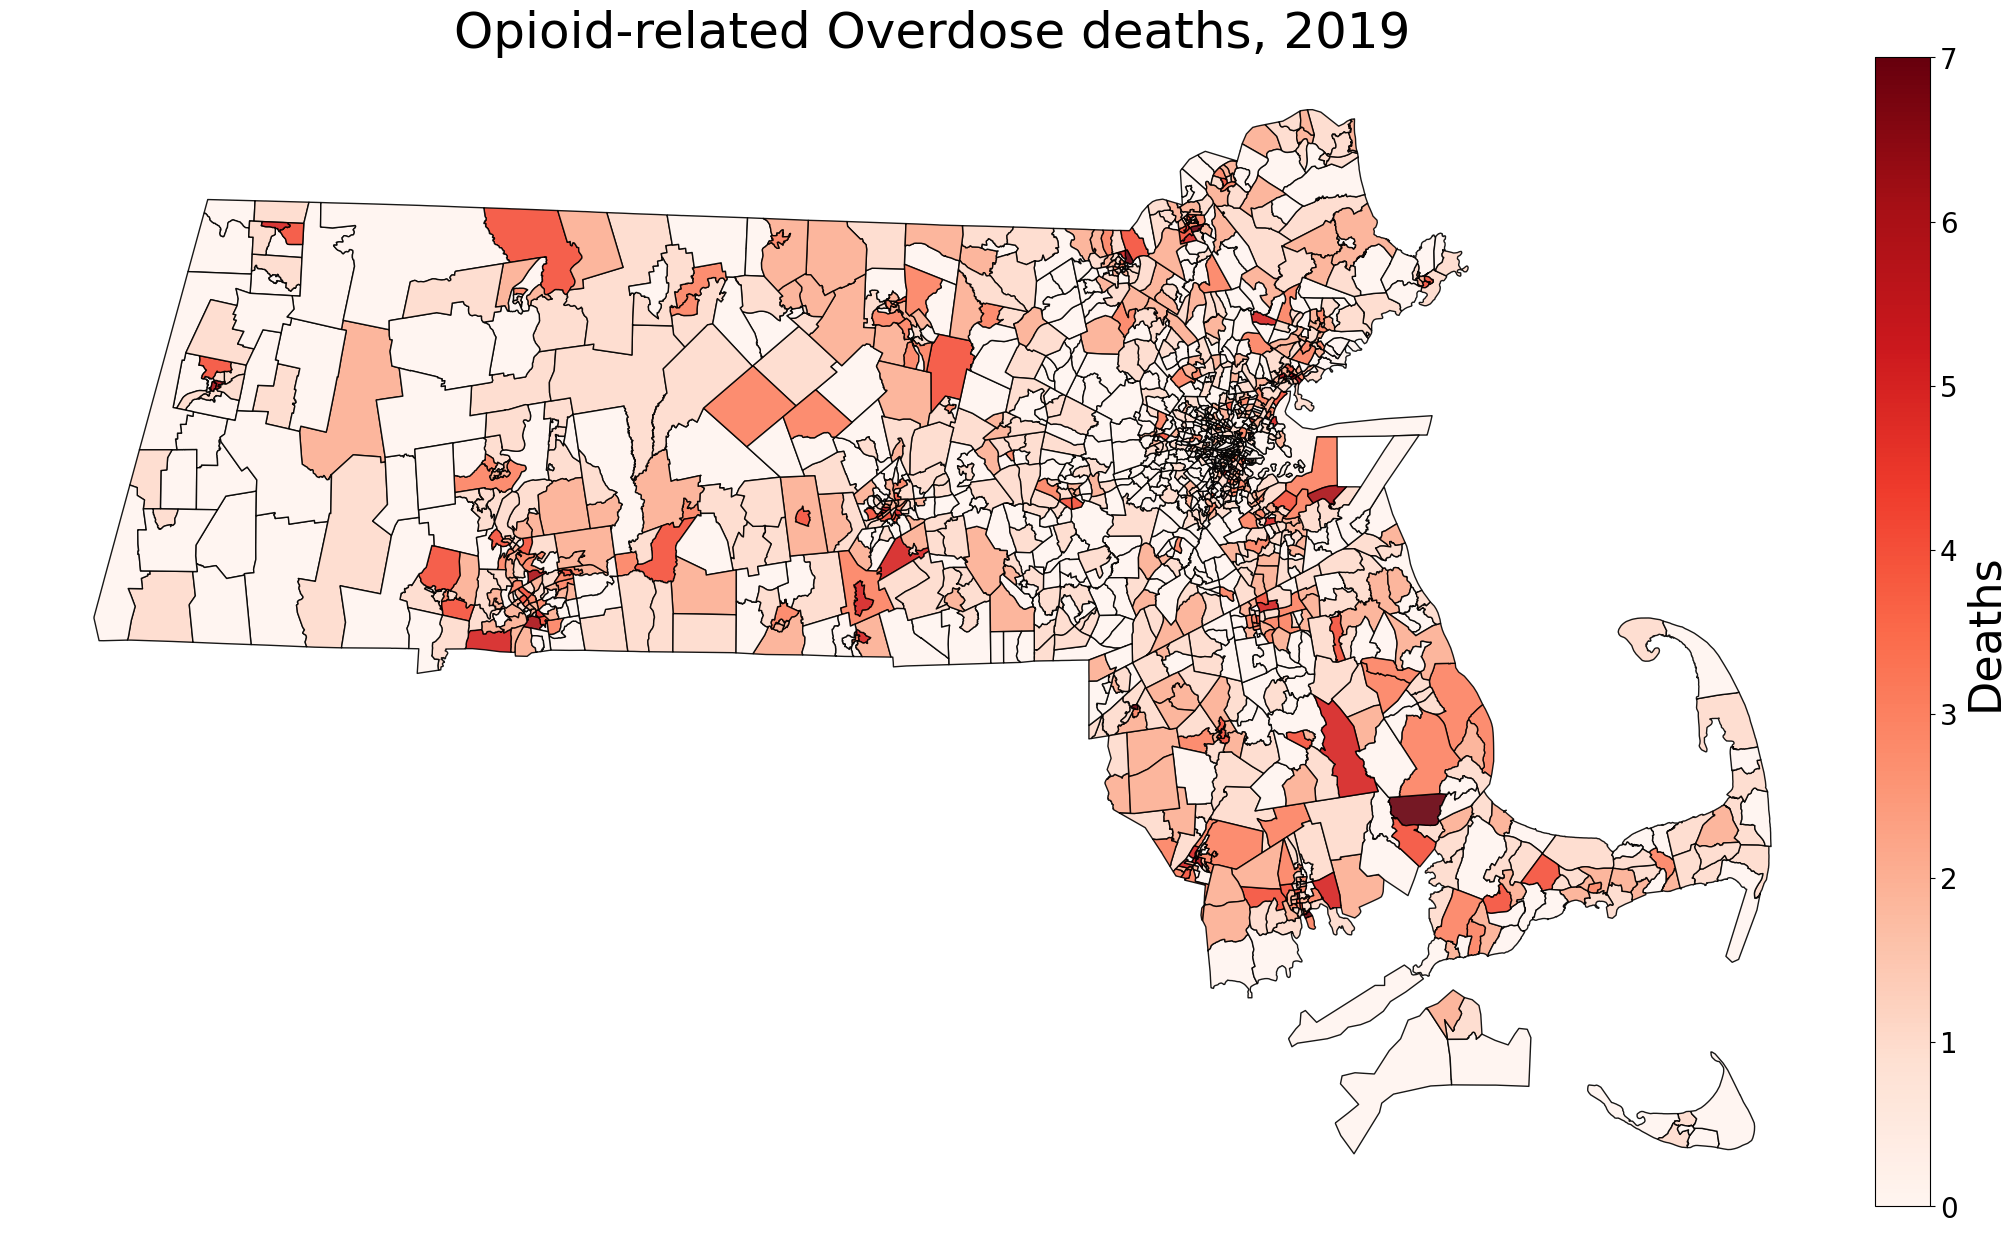

In [44]:
data='deaths'
cmap='Reds'
zoom=11
dpi=100

#w,s,e,n = states.total_bounds

residual_gdf.crs = "EPSG:4326"

cropped_gdf = residual_gdf[(residual_gdf['lat']>42.2)&(residual_gdf['lat']<42.4)&
                           (residual_gdf['lon']>-71.2)&(residual_gdf['lon']<-70.93)]

f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
minx, miny, maxx, maxy = cropped_gdf.to_crs(epsg=3857).total_bounds
#ax.set_xlim(minx, maxx-(maxx-minx)*0.4)
#ax.set_ylim(miny, maxy)
plt.title('Opioid-related Overdose deaths, 2019',fontsize=36)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = residual_gdf.to_crs(epsg=3857).plot(data, ax=ax, edgecolor='k', cmap=cmap,
                                         alpha = 0.9, legend=True, cax=cax)
cax.tick_params(labelsize=20)
#ctx.add_basemap(ux, zoom=zoom,reset_extent=True,source=ctx.providers.Esri.WorldTerrain);

plt.ylabel('Deaths', fontsize=32)
# Use savefig to save your map
# plt.savefig('State2019.png',bbox_inches='tight')
plt.show()

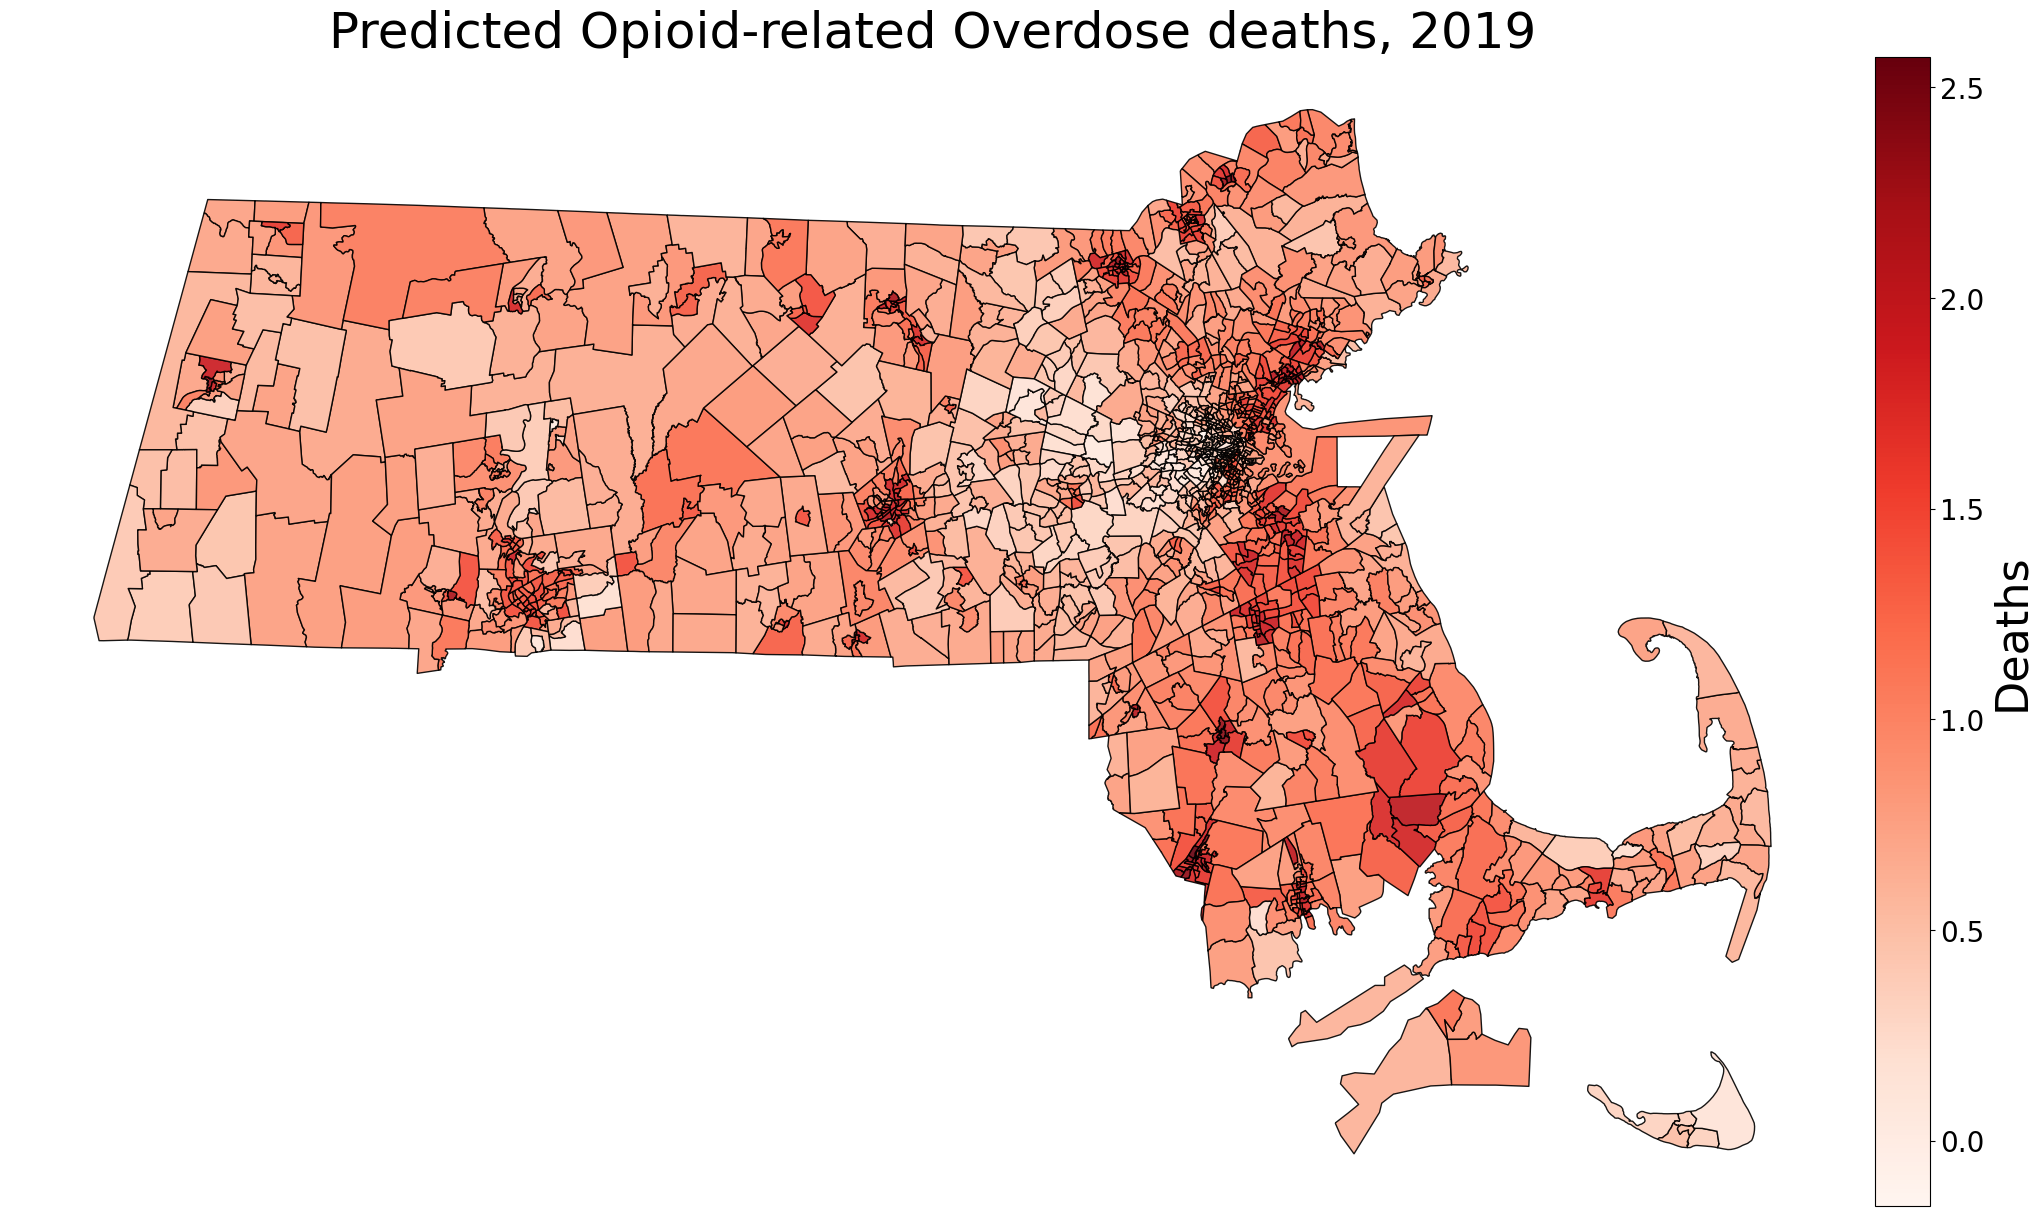

In [46]:
data='pred_deaths'
cmap='Reds'
zoom=11
dpi=100

#w,s,e,n = states.total_bounds

residual_gdf.crs = "EPSG:4326"

cropped_gdf = residual_gdf[(residual_gdf['lat']>42.2)&(residual_gdf['lat']<42.4)&
                           (residual_gdf['lon']>-71.2)&(residual_gdf['lon']<-70.93)]

f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
minx, miny, maxx, maxy = cropped_gdf.to_crs(epsg=3857).total_bounds
#ax.set_xlim(minx, maxx-(maxx-minx)*0.4)
#ax.set_ylim(miny, maxy)
plt.title('Predicted Opioid-related Overdose deaths, 2019',fontsize=36)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = residual_gdf.to_crs(epsg=3857).plot(data, ax=ax, edgecolor='k', cmap=cmap,
                                         alpha = 0.9, legend=True, cax=cax)
cax.tick_params(labelsize=20)
#ctx.add_basemap(ux, zoom=zoom,reset_extent=True,source=ctx.providers.Esri.WorldTerrain);

plt.ylabel('Deaths', fontsize=32)
# Use savefig to save your map
plt.savefig('State2019_preds.png',bbox_inches='tight')
plt.show()

KeyError: 'residuals'

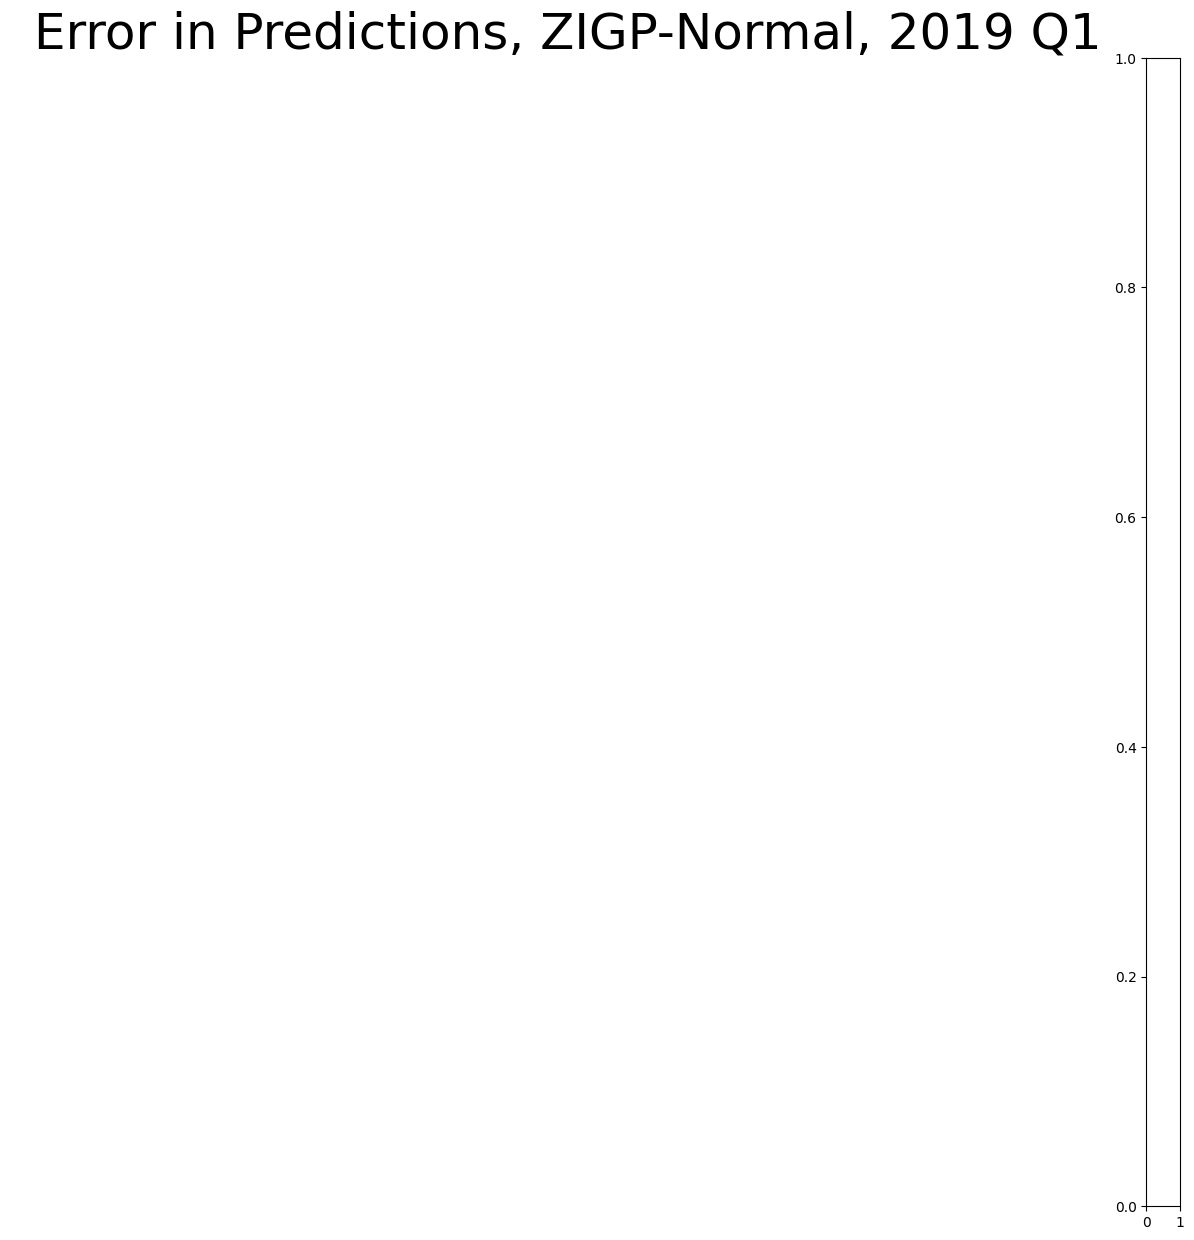

In [57]:
data='residuals'
cmap='RdBu_r'
zoom=11
dpi=100

#w,s,e,n = states.total_bounds

residual_gdf.crs = "EPSG:4326"

cropped_gdf = residual_gdf[(residual_gdf['lat']>42.2)&(residual_gdf['lat']<42.4)&
                           (residual_gdf['lon']>-71.2)&(residual_gdf['lon']<-70.93)]

f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
minx, miny, maxx, maxy = cropped_gdf.to_crs(epsg=3857).total_bounds
ax.set_xlim(minx, maxx-(maxx-minx)*0.4)
ax.set_ylim(miny, maxy)
plt.title('Error in Predictions, ZIGP-Normal, 2019 Q1',fontsize=36)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = residual_gdf.to_crs(epsg=3857).plot(data, ax=ax, edgecolor='k', cmap=cmap,
                                         vmin=-cropped_gdf_baseline['residuals'].max(),
                                         vmax=cropped_gdf_baseline['residuals'].max(),
                                         alpha = 0.2, legend=True, cax=cax)
cax.tick_params(labelsize=20)
ctx.add_basemap(ux, zoom=zoom,reset_extent=True,source=ctx.providers.Esri.WorldTerrain);

plt.ylabel('Error In Deaths (True-Predicted)', fontsize=32)
# Use savefig to save your map
#plt.savefig('map1zigp_N.png',bbox_inches='tight')
plt.show()

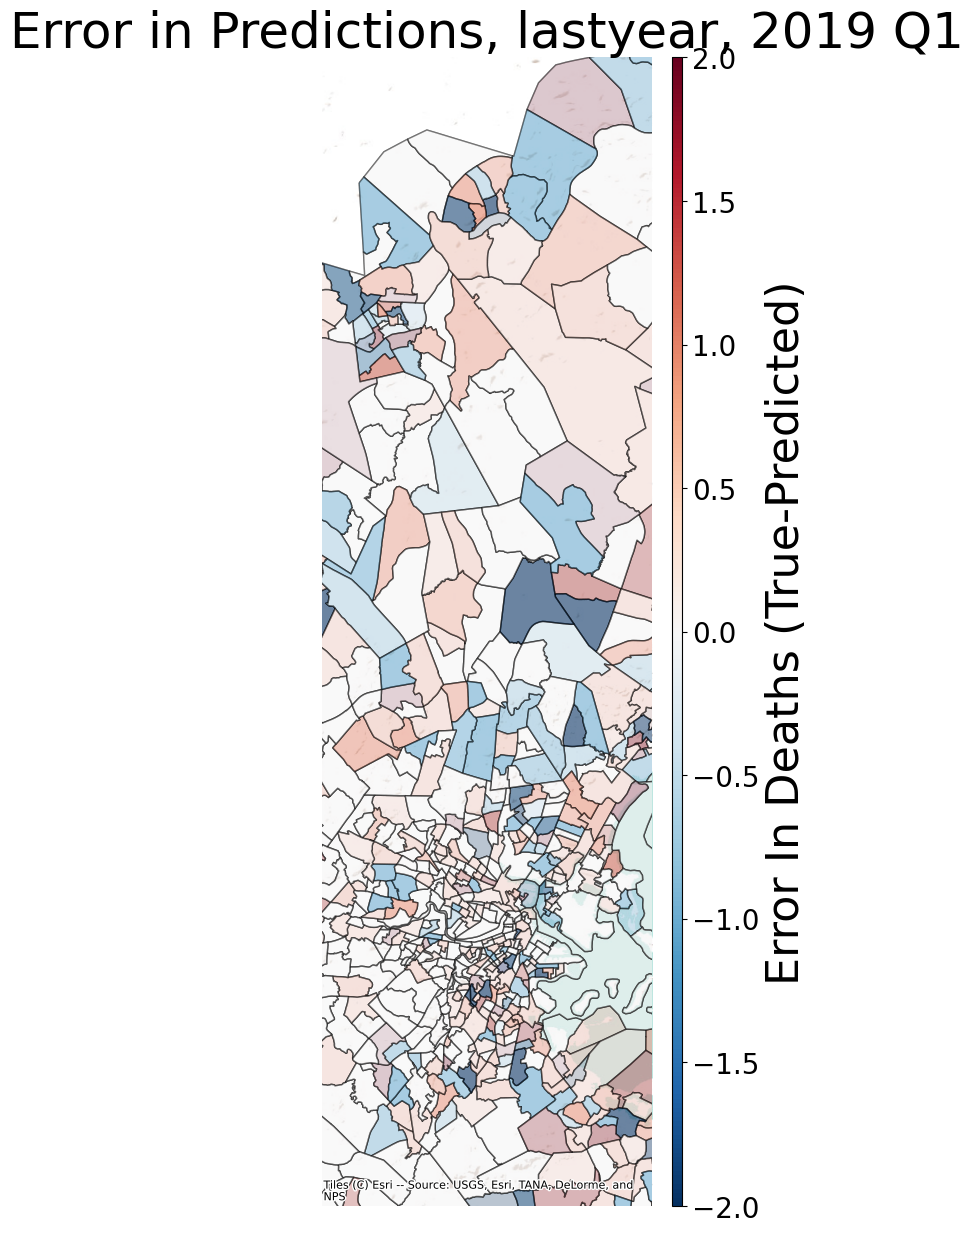

In [56]:
data='residuals'
cmap='RdBu_r'
zoom=11
dpi=100

#w,s,e,n = states.total_bounds

residual_baseline_gdf.crs = "EPSG:4326"

cropped_gdf_baseline = residual_baseline_gdf[(residual_baseline_gdf['lat']>42.2)&(residual_gdf['lat']<42.4)&
                           (residual_baseline_gdf['lon']>-71.2)&(residual_gdf['lon']<-70.93)]

f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
minx, miny, maxx, maxy = cropped_gdf_baseline.to_crs(epsg=3857).total_bounds
ax.set_xlim(minx, maxx-(maxx-minx)*0.4)
ax.set_ylim(miny, maxy)
plt.title('Error in Predictions, lastyear, 2019 Q1',fontsize=36)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = residual_baseline_gdf.to_crs(epsg=3857).plot(data, ax=ax, edgecolor='k', cmap=cmap,
                                         vmin=-cropped_gdf_baseline['residuals'].max(),
                                         vmax=cropped_gdf_baseline['residuals'].max(),
                                         alpha = 0.2, legend=True, cax=cax)
ctx.add_basemap(ux, zoom=zoom,reset_extent=True,source=ctx.providers.Esri.WorldTerrain);

cax.tick_params(labelsize=20)

plt.ylabel('Error In Deaths (True-Predicted)', fontsize=32)
# Use savefig to save your map
#plt.savefig('map1lastyear.png',bbox_inches='tight')
plt.show()

In [65]:
spring_lat = 42.1
spring_lon = -72.55

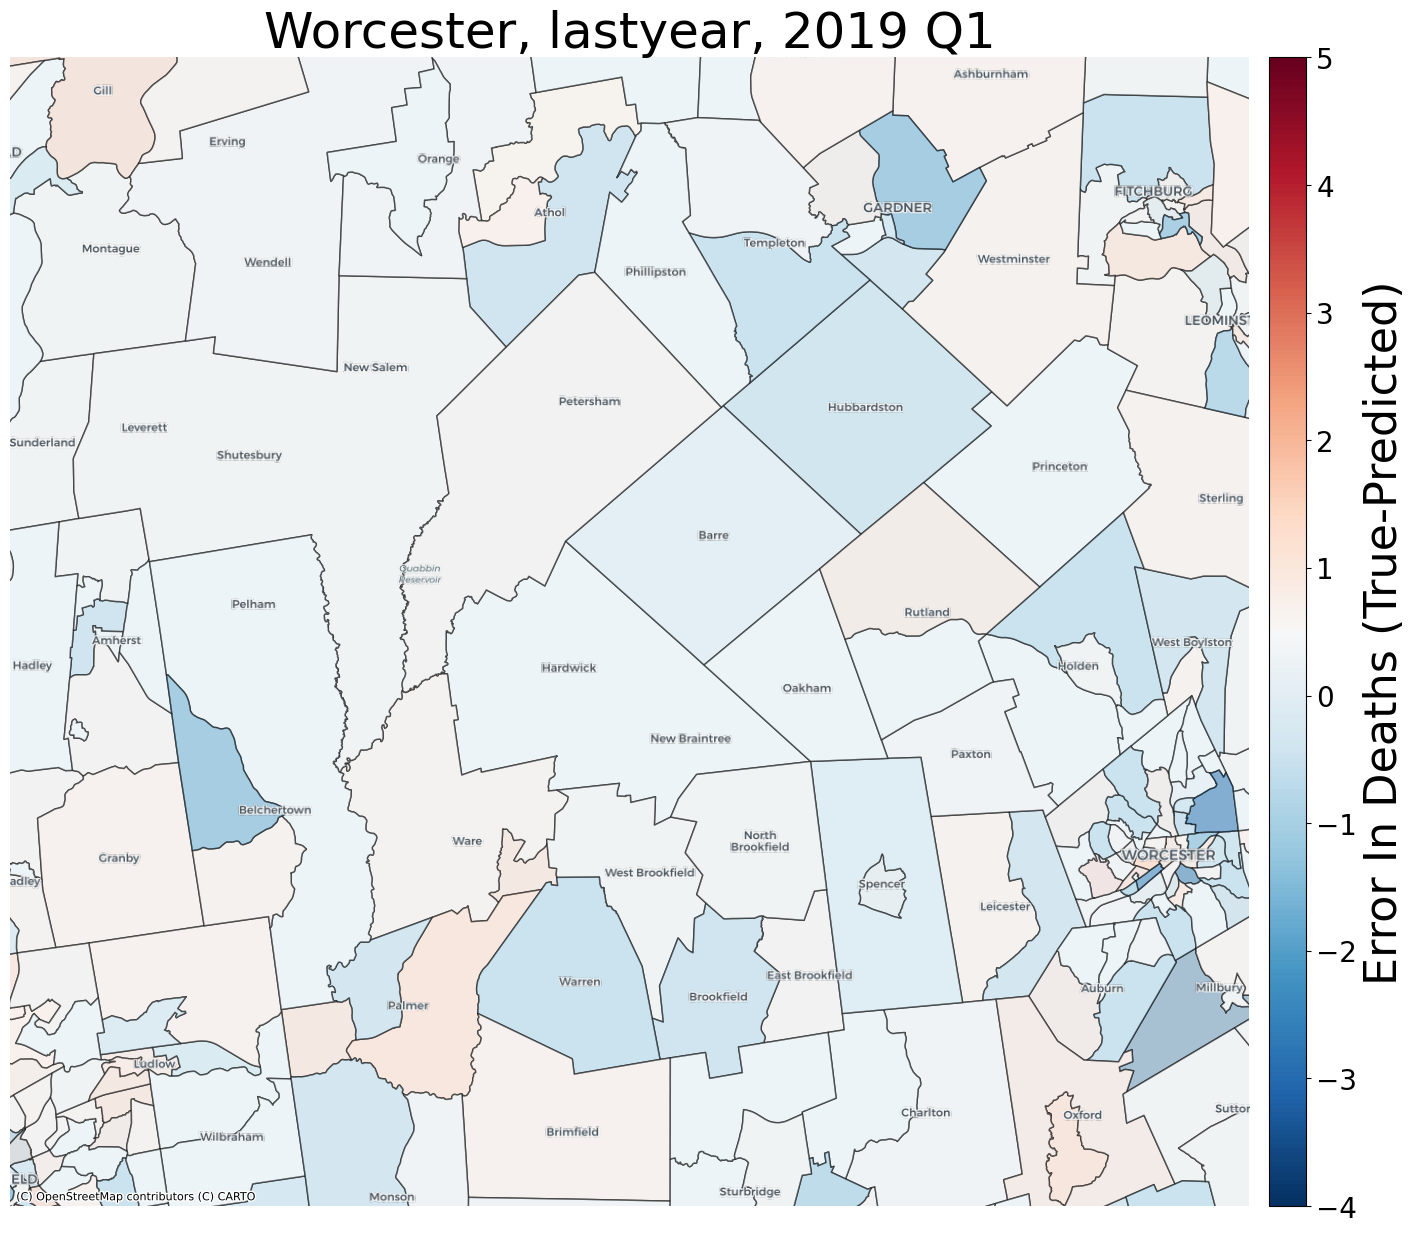

In [83]:
data='residuals'
cmap='RdBu_r'
zoom=11
dpi=100

#w,s,e,n = states.total_bounds

residual_baseline_gdf.crs = "EPSG:4326"

cropped_gdf_baseline = residual_baseline_gdf[(residual_baseline_gdf['lat']>spring_lat-lat_space)&(residual_gdf['lat']<spring_lat+lat_space)&
                           (residual_baseline_gdf['lon']>spring_lon-lon_space)&(residual_gdf['lon']<spring_lon+lon_space)]

f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
minx, miny, maxx, maxy = cropped_gdf_baseline.to_crs(epsg=3857).total_bounds
ax.set_xlim(minx, maxx-(maxx-minx)*0.4)
ax.set_ylim(miny, maxy)
plt.title('Worcester, lastyear, 2019 Q1',fontsize=36)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = residual_baseline_gdf.to_crs(epsg=3857).plot(data, ax=ax, edgecolor='k', cmap=cmap,
                                         alpha = 0.2, legend=True, cax=cax)
ctx.add_basemap(ux, zoom=zoom,reset_extent=True,source=ctx.providers.CartoDB.PositronOnlyLabels);

cax.tick_params(labelsize=20)

plt.ylabel('Error In Deaths (True-Predicted)', fontsize=32)
# Use savefig to save your map
#plt.savefig('map1lastyear.png',bbox_inches='tight')
plt.show()

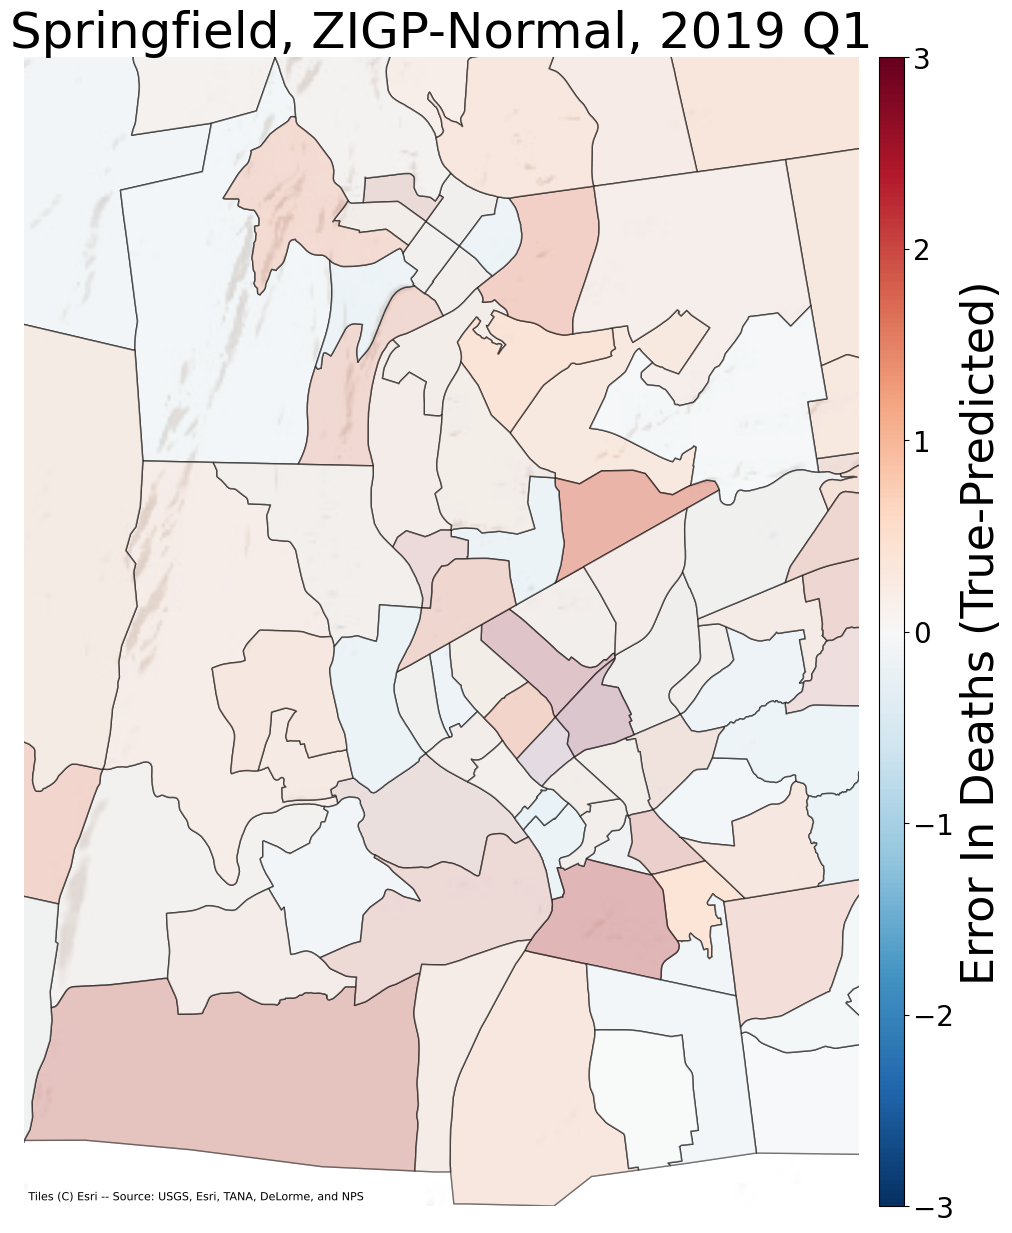

In [48]:
data='residuals'
cmap='RdBu_r'
zoom=11
dpi=100

#w,s,e,n = states.total_bounds

residual_gdf.crs = "EPSG:4326"

cropped_gdf =  residual_gdf[(residual_gdf['lat']>spring_lat-lat_space)&(residual_gdf['lat']<spring_lat+lat_space)&
                           (residual_gdf['lon']>spring_lon-lon_space)&(residual_gdf['lon']<spring_lon+lon_space)]


f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
minx, miny, maxx, maxy = cropped_gdf.to_crs(epsg=3857).total_bounds
ax.set_xlim(minx, maxx-(maxx-minx)*0.4)
ax.set_ylim(miny, maxy)
plt.title('Springfield, ZIGP-Normal, 2019 Q1',fontsize=36)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = residual_gdf.to_crs(epsg=3857).plot(data, ax=ax, edgecolor='k', cmap=cmap,
                                         vmin=-cropped_gdf_baseline['residuals'].max(),
                                         vmax=cropped_gdf_baseline['residuals'].max(),
                                         alpha = 0.2, legend=True, cax=cax)
cax.tick_params(labelsize=20)
ctx.add_basemap(ux, zoom=zoom,reset_extent=True,source=ctx.providers.Esri.WorldTerrain);

plt.ylabel('Error In Deaths (True-Predicted)', fontsize=32)
# Use savefig to save your map
#plt.savefig('map1zigp_N.png',bbox_inches='tight')
plt.show()

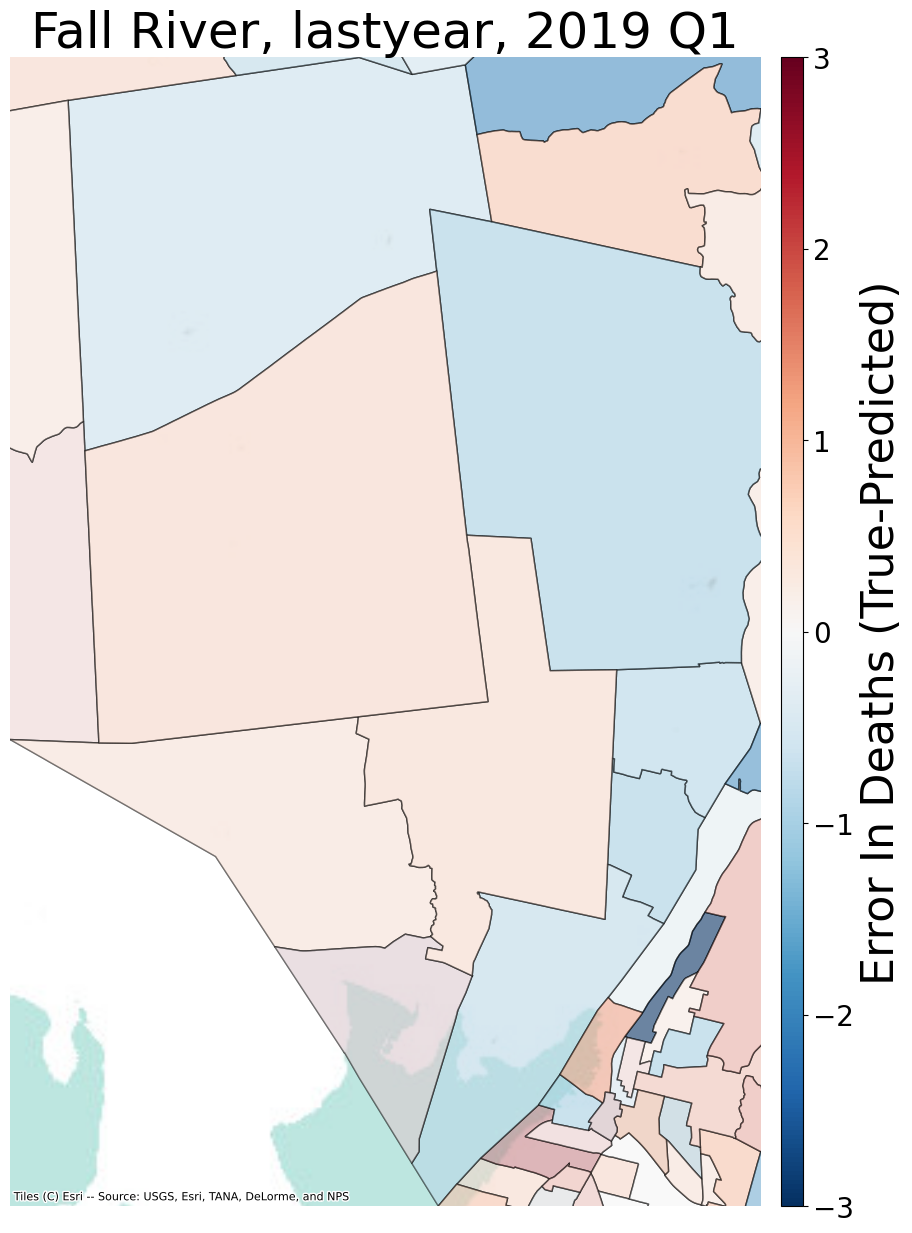

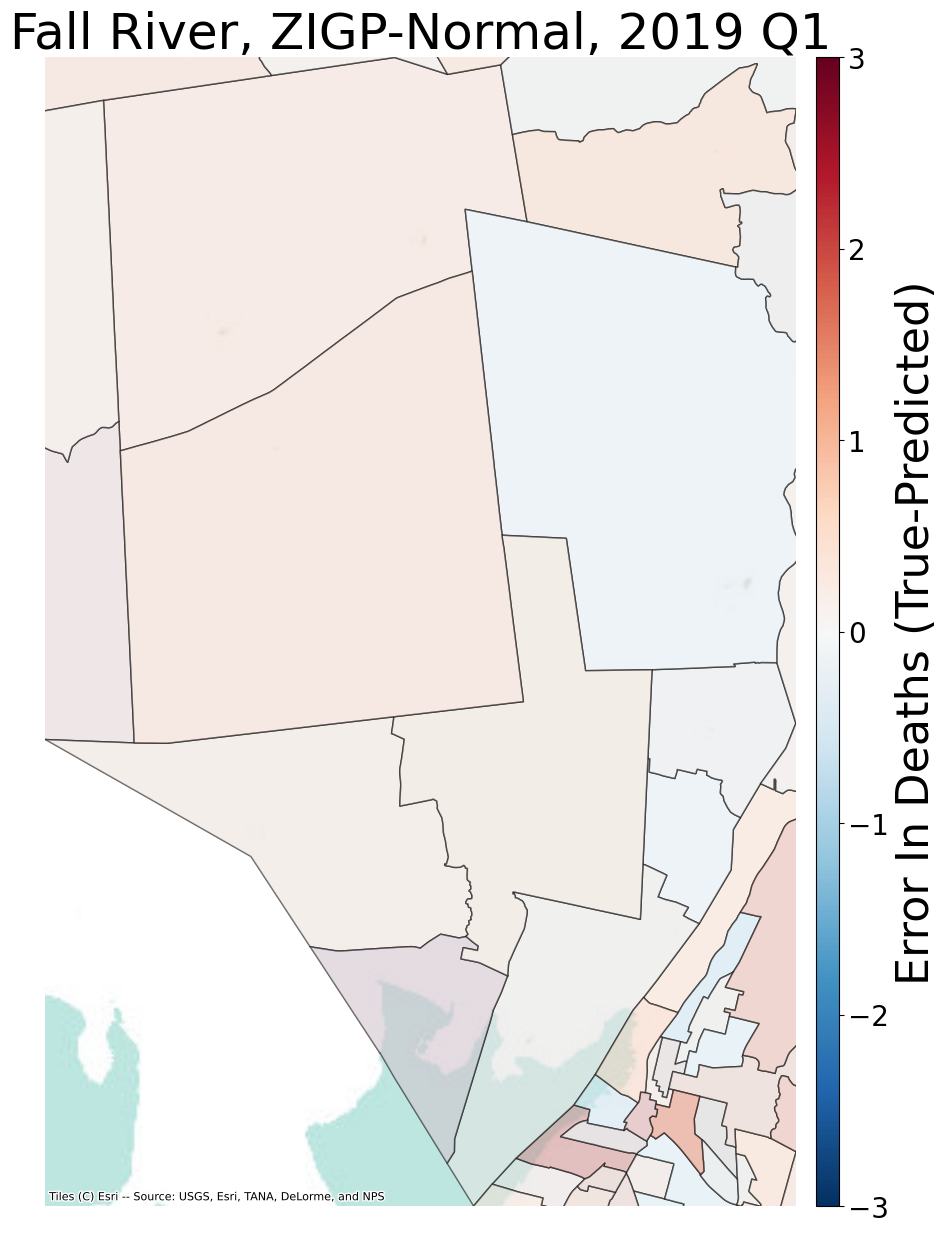

In [54]:
city = "Fall River"
lat = 41.8
lon = -71.15

data='residuals'
cmap='RdBu_r'
zoom=11
dpi=100

#w,s,e,n = states.total_bounds

residual_baseline_gdf.crs = "EPSG:4326"

cropped_gdf_baseline = residual_baseline_gdf[(residual_baseline_gdf['lat']>lat-lat_space)&(residual_gdf['lat']<lat+lat_space)&
                           (residual_baseline_gdf['lon']>lon-lon_space)&(residual_gdf['lon']<lon+lon_space)]

f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
minx, miny, maxx, maxy = cropped_gdf_baseline.to_crs(epsg=3857).total_bounds
ax.set_xlim(minx, maxx-(maxx-minx)*0.4)
ax.set_ylim(miny, maxy)
plt.title(f'{city}, lastyear, 2019 Q1',fontsize=36)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = residual_baseline_gdf.to_crs(epsg=3857).plot(data, ax=ax, edgecolor='k', cmap=cmap,
                                         vmin=-cropped_gdf_baseline['residuals'].max(),
                                         vmax=cropped_gdf_baseline['residuals'].max(),
                                         alpha = 0.2, legend=True, cax=cax)
ctx.add_basemap(ux, zoom=zoom,reset_extent=True,source=ctx.providers.Esri.WorldTerrain);

cax.tick_params(labelsize=20)

plt.ylabel('Error In Deaths (True-Predicted)', fontsize=32)
# Use savefig to save your map
#plt.savefig('map1lastyear.png',bbox_inches='tight')
plt.show()

data='residuals'
cmap='RdBu_r'
zoom=11
dpi=100

#w,s,e,n = states.total_bounds

residual_gdf.crs = "EPSG:4326"

cropped_gdf =  residual_gdf[(residual_gdf['lat']>lat-lat_space)&(residual_gdf['lat']<lat+lat_space)&
                           (residual_gdf['lon']>lon-lon_space)&(residual_gdf['lon']<lon+lon_space)]


f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
minx, miny, maxx, maxy = cropped_gdf.to_crs(epsg=3857).total_bounds
ax.set_xlim(minx, maxx-(maxx-minx)*0.4)
ax.set_ylim(miny, maxy)
plt.title(f'{city}, ZIGP-Normal, 2019 Q1',fontsize=36)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = residual_gdf.to_crs(epsg=3857).plot(data, ax=ax, edgecolor='k', cmap=cmap,
                                         vmin=-cropped_gdf_baseline['residuals'].max(),
                                         vmax=cropped_gdf_baseline['residuals'].max(),
                                         alpha = 0.2, legend=True, cax=cax)
cax.tick_params(labelsize=20)
ctx.add_basemap(ux, zoom=zoom,reset_extent=True,source=ctx.providers.Esri.WorldTerrain);

plt.ylabel('Error In Deaths (True-Predicted)', fontsize=32)
# Use savefig to save your map
#plt.savefig('map1zigp_N.png',bbox_inches='tight')
plt.show()

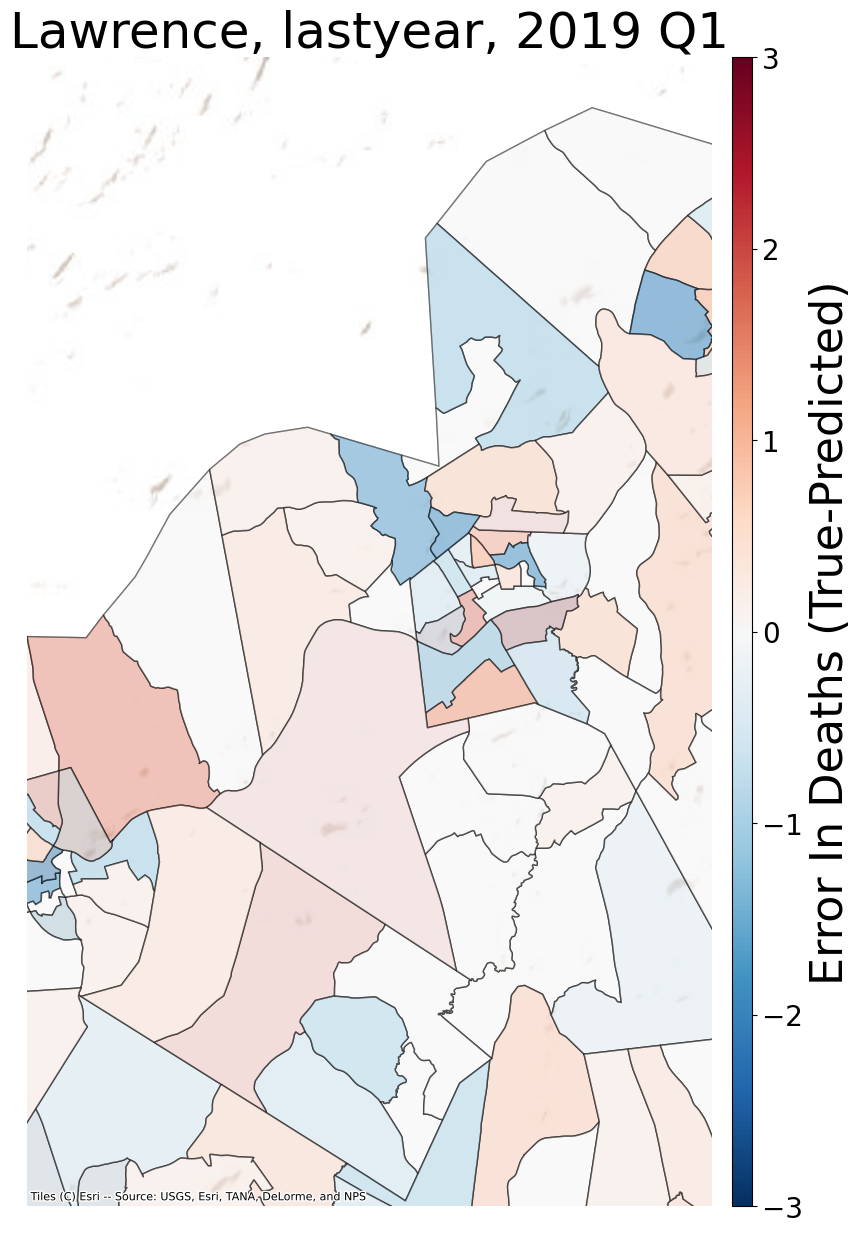

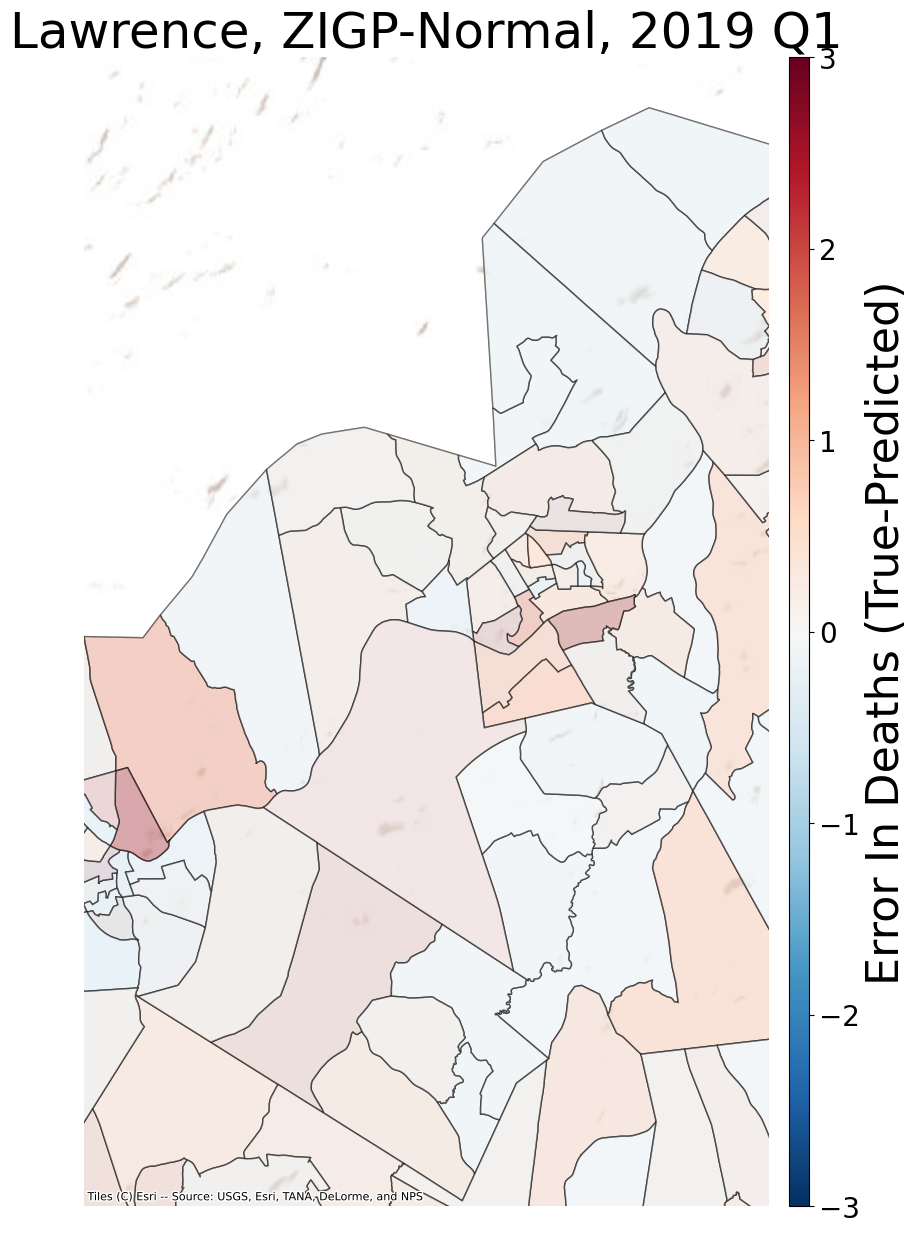

In [56]:
city = "Lawrence"
lat = 42.7
lon = -71.15

data='residuals'
cmap='RdBu_r'
zoom=11
dpi=100

#w,s,e,n = states.total_bounds

residual_baseline_gdf.crs = "EPSG:4326"

cropped_gdf_baseline = residual_baseline_gdf[(residual_baseline_gdf['lat']>lat-lat_space)&(residual_gdf['lat']<lat+lat_space)&
                           (residual_baseline_gdf['lon']>lon-lon_space)&(residual_gdf['lon']<lon+lon_space)]

f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
minx, miny, maxx, maxy = cropped_gdf_baseline.to_crs(epsg=3857).total_bounds
ax.set_xlim(minx, maxx-(maxx-minx)*0.4)
ax.set_ylim(miny, maxy)
plt.title(f'{city}, lastyear, 2019 Q1',fontsize=36)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = residual_baseline_gdf.to_crs(epsg=3857).plot(data, ax=ax, edgecolor='k', cmap=cmap,
                                         vmin=-cropped_gdf_baseline['residuals'].max(),
                                         vmax=cropped_gdf_baseline['residuals'].max(),
                                         alpha = 0.2, legend=True, cax=cax)
ctx.add_basemap(ux, zoom=zoom,reset_extent=True,source=ctx.providers.Esri.WorldTerrain);

cax.tick_params(labelsize=20)

plt.ylabel('Error In Deaths (True-Predicted)', fontsize=32)
# Use savefig to save your map
#plt.savefig('map1lastyear.png',bbox_inches='tight')
plt.show()

data='residuals'
cmap='RdBu_r'
zoom=11
dpi=100

#w,s,e,n = states.total_bounds

residual_gdf.crs = "EPSG:4326"

cropped_gdf =  residual_gdf[(residual_gdf['lat']>lat-lat_space)&(residual_gdf['lat']<lat+lat_space)&
                           (residual_gdf['lon']>lon-lon_space)&(residual_gdf['lon']<lon+lon_space)]


f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
minx, miny, maxx, maxy = cropped_gdf.to_crs(epsg=3857).total_bounds
ax.set_xlim(minx, maxx-(maxx-minx)*0.4)
ax.set_ylim(miny, maxy)
plt.title(f'{city}, ZIGP-Normal, 2019 Q1',fontsize=36)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = residual_gdf.to_crs(epsg=3857).plot(data, ax=ax, edgecolor='k', cmap=cmap,
                                         vmin=-cropped_gdf_baseline['residuals'].max(),
                                         vmax=cropped_gdf_baseline['residuals'].max(),
                                         alpha = 0.2, legend=True, cax=cax)
cax.tick_params(labelsize=20)
ctx.add_basemap(ux, zoom=zoom,reset_extent=True,source=ctx.providers.Esri.WorldTerrain);

plt.ylabel('Error In Deaths (True-Predicted)', fontsize=32)
# Use savefig to save your map
#plt.savefig('map1zigp_N.png',bbox_inches='tight')
plt.show()

In [55]:
cropped_gdf_baseline

grid_squar                                           geometry  \
432   25005642100  POLYGON ((-71.15545 41.72380, -71.15542 41.723...   
433   25005642100  POLYGON ((-71.15545 41.72380, -71.15542 41.723...   
434   25005642100  POLYGON ((-71.15545 41.72380, -71.15542 41.723...   
435   25005642100  POLYGON ((-71.15545 41.72380, -71.15542 41.723...   
436   25005642200  POLYGON ((-71.15101 41.71589, -71.15007 41.716...   
...           ...                                                ...   
4807  25005613902  POLYGON ((-71.13487 41.88566, -71.13469 41.885...   
6008  25005613901  POLYGON ((-71.11736 41.89559, -71.11723 41.895...   
6009  25005613901  POLYGON ((-71.11736 41.89559, -71.11723 41.895...   
6010  25005613901  POLYGON ((-71.11736 41.89559, -71.11723 41.895...   
6011  25005613901  POLYGON ((-71.11736 41.89559, -71.11723 41.895...   

            lat        lon  haversine  timestep  deaths  pred_deaths  \
432   41.755652 -71.125009  94.287045      76.0     1.0          1.0   
433   41.755652 -71.125009  94.287045      77.0     0.0          1.0   
434   41.755652 -71.125009  94.287045      78.0     1.0          1.0   
435   41.755652 -71.125009  94.287045      79.0     1.0          1.0   
436   41.728450 -71.136773  97.384103      76.0     0.0          3.0   
...         ...        ...        ...       ...     ...          ...   
4807  41.872794 -71.113664  81.228284      79.0     1.0          0.0   
6008  41.897595 -71.111153  78.462817      76.0     0.0          1.0   
6009  41.897595 -71.111153  78.462817      77.0     1.0          1.0   
6010  41.897595 -71.111153  78.462817      78.0     1.0          1.0   
6011  41.897595 -71.111153  78.462817      79.0     0.0          1.0   

      residuals  
432         0.0  
433        -1.0  
434         0.0  
435         0.0  
436        -3.0  
...         ...  
4807        1.0  
6008       -1.0  
6009        0.0  
6010        0.0  
6011       -1.0  

[104 rows x 9 columns]

In [92]:
comparisons = pd.read_csv(os.path.join(result_dir,'comparisons.csv'))
comparisons

name      lat      lon  center  \
0   N. Cambridge  42.3934 -71.1309     607   
1  Jamaica Plain  42.3132 -71.1141     605   
2    Springfield  42.1015 -72.5898     206   
3     Pittsfield  42.4501 -73.2454      43   
4       Brockton  42.0834 -71.0184     651   
5       Lawrence  42.7070 -71.1631     612   
6      Nantucket  41.2835 -70.0995     918   
7       Falmouth  41.5532 -70.6086     848   

                               neighbors  
0  [581 582 583 606 607 608 631 632 633]  
1  [579 580 581 604 605 606 629 630 631]  
2  [191 192 193 205 206 207 219 220 221]  
3           [29 30 31 42 43 44 56 57 58]  
4  [625 626 627 650 651 652 678 679 680]  
5  [586 587 588 611 612 613 636 637 638]  
6          [911 917 918 919 928 929 930]  
7  [827 828 829 847 848 849 863 864 865]

Text(0.5, 1.05, 'Data for comparison locations, 2001-2019')

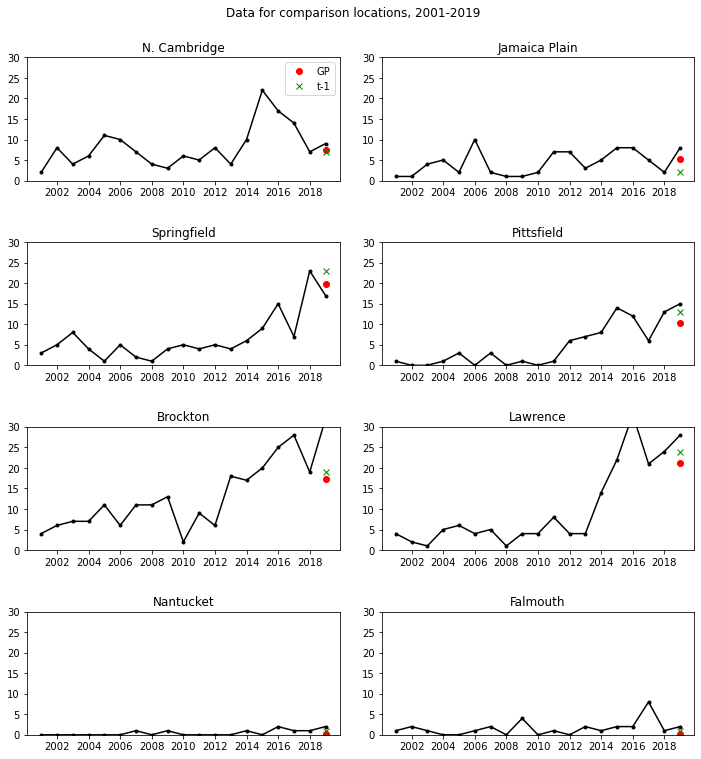

In [105]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10,10))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
for c, comparison in comparisons.iterrows():
    row = int(np.floor(c/2))
    col = c%2
    ax = axs[row, col]
    

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim([0,30])
    ax.set_title(comparison['name'])
        
    avg =  train_y_through_2019[train_y_through_2019['grid_squar']==comparison['center']].groupby('year').mean()['deaths']
    ax.plot(np.arange(2001, 2020), avg, 'k.-')
    
    ax.plot(2019, pred_2019_df.loc[comparison['center']],'ro', label='GP')
    ax.plot(2019,train_y_through_2019[(train_y_through_2019['grid_squar']==comparison['center'])&(train_y_through_2019['year']==2018)]['deaths'],'gx', label='t-1')
    if row==col==0:
        ax.legend()
fig.suptitle("Data for comparison locations, 2001-2019",y=1.05)

In [96]:
pred_2019_df

grid_squar
0      0.000336
1      0.000456
2      0.000477
3      0.000445
4      0.000415
         ...   
957    0.132581
958    0.021528
959    0.090112
960    0.000920
961    0.000781
Length: 962, dtype: float64

In [100]:
train_y_through_2019[(train_y_through_2019['grid_squar']==comparison['center'])&(train_y_through_2019['year']==2018)]['deaths']

grid_squar  year  deaths
17202         848  2018     1.0

In [52]:
import scipy

In [53]:
scipy.__version__

'1.5.4'

In [25]:
m.savemodel?

In [28]:
m.savemodel('/cluster/home/kheuto01/testsavemodel.mod')

In [31]:
dir(m)

['ProbitExpectations',
 'X',
 'Xtrain',
 'Y',
 'Ytrain',
 'Zf',
 'Zg',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_begin_tf_mode',
 '_end_tf_mode',
 '_html_table_rows',
 '_kill_autoflow',
 '_name',
 '_needs_recompile',
 '_optimize_np',
 '_optimize_tf',
 '_parent',
 '_repr_html_',
 '_session',
 '_tf_mode',
 'build_likelihood',
 'build_predict',
 'build_prior',
 'build_prior_KL',
 'compile',
 'compute_log_likelihood',
 'compute_log_prior',
 'compute_prior_KL',
 'data_holders',
 'fixed',
 'get_feed_dict_keys',
 'get_free_state',
 'get_param_index',
 'get_parameter_dict',
 'get_samples_df',
 'highest_parent',
 'kernf',
 'kerng',
 'li

In [30]:
OnOffSVGP.update_feed_dict?

In [32]:
m.set_parameter_dict?

In [25]:
with open('/cluster/tufts/hugheslab/kheuto01/opioid/logs/qtr/ind100_iter3000/model.pkl','rb') as f:
    m = pickle.load(f)

In [24]:
import pickle

In [6]:
gpflow.__version__

'2.5.2'

In [29]:
def fixed_top_X(true_qtr_val,pred_qtr_val, X=10):
    
    top_X_predicted = pred_qtr_val.sort_values(ascending=False)[:X]
    top_X_true = true_qtr_val.sort_values(ascending=False)[:X]


    undisputed_top_predicted = top_X_predicted[top_X_predicted>top_X_predicted.min()]
    num_tied_spots = X - len(undisputed_top_predicted)
    undisputed_top_true = top_X_true[top_X_true > top_X_true.min()]
    num_true_ties = X - len(undisputed_top_true)


    tied_top_predicted = pred_qtr_val[pred_qtr_val==top_X_predicted.min()]
    tied_top_true = true_qtr_val[true_qtr_val==top_X_true.min()]

    error_in_top_true_ties = np.abs(tied_top_true-pred_qtr_val[tied_top_true.index]).sort_values(ascending=True)
    error_in_top_pred_ties = np.abs(true_qtr_val[tied_top_predicted.index]-tied_top_predicted).sort_values(ascending=True)
    top_true_tied_geoids = error_in_top_true_ties[:num_true_ties].index
    top_pred_tied_geoids = error_in_top_pred_ties[:num_tied_spots].index

    best_possible_top_true_geoids = pd.Index.union(undisputed_top_true.index, top_true_tied_geoids)
    best_possible_top_pred_geoids = pd.Index.union(undisputed_top_predicted.index, top_pred_tied_geoids)

    # True values of GEOIDS with highest actual deaths. If ties, finds tied locations that match preds best
    best_possible_true = true_qtr_val[best_possible_top_true_geoids]
    best_possible_pred = true_qtr_val[best_possible_top_pred_geoids]

    assert(len(best_possible_true)==X)
    assert(len(best_possible_pred)==X)

    best_possible_absolute = np.abs(best_possible_true.sum() - best_possible_pred.sum())
    best_possible_ratio = np.abs(best_possible_pred).sum()/np.abs(best_possible_true).sum()


    bootstrapped_tied_indices = np.random.choice(tied_top_predicted.index, (1000, num_tied_spots))
    bootstrapped_all_indices =  [pd.Index.union(undisputed_top_predicted.index,
                                                bootstrap_index) for bootstrap_index in bootstrapped_tied_indices]

    bootstrapped_absolute = np.mean([np.abs(top_X_true.sum() - true_qtr_val[indices].sum()) 
                                     for indices in bootstrapped_all_indices])
    bootstrapped_ratio = np.mean([np.abs(true_qtr_val[indices]).sum()/np.abs(top_X_true).sum()
                                  for indices in bootstrapped_all_indices])
    
    return best_possible_absolute, best_possible_ratio, bootstrapped_absolute, bootstrapped_ratio

In [91]:
maes = []
xtop = []
for quarter in range(1,4+1):
    test_x = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
    test_y = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['grid_squar','timestep', 'deaths']]
    sg_2019 = m.predict_onoffgp(test_x.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values)
    sg_2019 = sg_2019[0]
    pred_2019_df = pd.Series(sg_2019.squeeze(), index=x_just_2019q1.grid_squar)

    maes.append(mean_absolute_error(test_y.deaths, pred_2019_df))
    xtop.append(fixed_top_X(test_y.set_index('grid_squar')['deaths'], pred_2019_df, 100))
print(np.mean(maes))
print(np.mean([thing[3] for thing in xtop]))

0.4051279606661234
0.3296924351877911


In [89]:
 m.build_predict(test_x.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values)

TypeError: Failed to convert object of type <class 'gpflow.param.Param'> to Tensor. Contents: [1mZf[0m transform:(none) prior:None
[[ 4.08227986e+01 -7.08902698e+01  5.62334584e+01 ...  9.36997797e-01
   4.43697428e-01 -1.49229399e-01]
 [ 4.09596624e+01 -7.19512720e+01  5.81139416e+01 ... -1.47802539e-01
  -3.90566566e-01  1.24074205e-01]
 [ 4.21730109e+01 -7.16430800e+01  5.90026438e+01 ...  7.11397415e-01
   4.71247504e-01  4.19486636e-01]
 ...
 [ 4.26319012e+01 -7.08945840e+01  5.02059646e+01 ...  1.20500757e+00
   5.77575826e-01  4.27321400e-01]
 [ 4.12154233e+01 -7.19608157e+01  1.77871251e+01 ...  1.07416481e+00
   1.45470173e-01 -2.81690370e-01]
 [ 4.04555213e+01 -7.10156803e+01  5.40190133e+01 ...  2.85425099e-01
  -5.43120338e-03 -9.55941440e-02]]. Consider casting elements to a supported type.

In [42]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import contextily as ctx 
import geopandas as gpd 
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [138]:
plt.xlim([-71.2, -70.9])
plt.ylim([42, 42.6])

42.886778

In [145]:
residual_gdf.plot?

In [153]:
minx

-73.50821

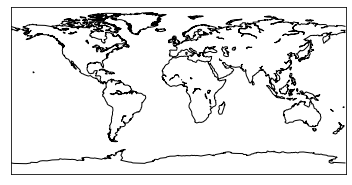

In [212]:
from mpl_toolkits.basemap import Basemap
m=Basemap()
 
# Show the coast lines
m.drawcoastlines()

In [231]:
deaths_and_preds

grid_squar  timestep  deaths  pred_deaths  residuals
76      25001010100      76.0     0.0     0.198882  -0.198882
77      25001010100      77.0     0.0     0.198882  -0.198882
78      25001010100      78.0     1.0     0.198882   0.801118
79      25001010100      79.0     0.0     0.198882  -0.198882
164     25001010206      76.0     0.0     0.177260  -0.177260
...             ...       ...     ...          ...        ...
142463  25027761401      79.0     0.0     0.161939  -0.161939
142548  25027761402      76.0     0.0     0.166395  -0.166395
142549  25027761402      77.0     0.0     0.166395  -0.166395
142550  25027761402      78.0     0.0     0.166395  -0.166395
142551  25027761402      79.0     0.0     0.166395  -0.166395

[6480 rows x 5 columns]

In [50]:
dir(cax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_locator',
 '_axisbelow',
 '_box_aspect',
 '_clipon',
 '_clippath',
 '_contains',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_axis_map',
 '_get_clipping_extent_bbox',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_in_layout',
 '_init_axis',


In [100]:
deaths_gdf

STATEFP COUNTYFP TRACTCE     NAME  \
grid_squar  year quarter                                     
25001010100 2000 1            25      001   10100      101   
                 2            25      001   10100      101   
                 3            25      001   10100      101   
                 4            25      001   10100      101   
            2001 1            25      001   10100      101   
...                          ...      ...     ...      ...   
25027761402 2020 4            25      027  761402  7614.02   
            2021 1            25      027  761402  7614.02   
                 2            25      027  761402  7614.02   
                 3            25      027  761402  7614.02   
                 4            25      027  761402  7614.02   

                                      NAMELSAD  MTFCC FUNCSTAT     ALAND  \
grid_squar  year quarter                                                   
25001010100 2000 1            Census Tract 101  G5020        S  25046216   
                 2            Census Tract 101  G5020        S  25046216   
                 3            Census Tract 101  G5020        S  25046216   
                 4            Census Tract 101  G5020        S  25046216   
            2001 1            Census Tract 101  G5020        S  25046216   
...                                        ...    ...      ...       ...   
25027761402 2020 4        Census Tract 7614.02  G5020        S  25568170   
            2021 1        Census Tract 7614.02  G5020        S  25568170   
                 2        Census Tract 7614.02  G5020        S  25568170   
                 3        Census Tract 7614.02  G5020        S  25568170   
                 4        Census Tract 7614.02  G5020        S  25568170   

                            AWATER        lat  ...  theme_4_pc  svi_pctile  \
grid_squar  year quarter                       ...                           
25001010100 2000 1        12765872  42.059829  ...      0.6872      0.6230   
                 2        12765872  42.059829  ...      0.6872      0.6230   
                 3        12765872  42.059829  ...      0.6872      0.6230   
                 4        12765872  42.059829  ...      0.6872      0.6230   
            2001 1        12765872  42.059829  ...      0.6872      0.6230   
...                            ...        ...  ...         ...         ...   
25027761402 2020 4          209089  42.531342  ...      0.1598      0.2237   
            2021 1          209089  42.531342  ...      0.1598      0.2237   
                 2          209089  42.531342  ...      0.1598      0.2237   
                 3          209089  42.531342  ...      0.1598      0.2237   
                 4          209089  42.531342  ...      0.1598      0.2237   

                                 FIPS  ROUNDED_TR  ROUNDED__1  TRACTCE_y  \
grid_squar  year quarter                                                   
25001010100 2000 1        25001010100        None        None       None   
                 2        25001010100        None        None       None   
                 3        25001010100        None        None       None   
                 4        25001010100        None        None       None   
            2001 1        25001010100        None        None       None   
...                               ...         ...         ...        ...   
25027761402 2020 4               None      761400      761400       None   
            2021 1               None      761400      761400       None   
                 2               None      761400      761400       None   
                 3               None      761400      761400       None   
                 4               None      761400      761400       None   

                                                                   geometry  \
grid_squar  year quarter                                                      
25001010100 2000 1        POLYGON ((-70.25001 42.06410, -70.24959 4

In [109]:
for year in range(2000,2022):
    sparsity =  deaths_gdf.loc[:,year,:][deaths_gdf.loc[:,year,:]['deaths']==0]['deaths'].count()/deaths_gdf.loc[:,year,:]['deaths'].count()
    print(f'{year}, {sparsity}')

2000, 0.9467592592592593
2001, 0.9367283950617284
2002, 0.9304012345679012
2003, 0.9138888888888889
2004, 0.9313271604938271
2005, 0.9229938271604938
2006, 0.9125
2007, 0.9145061728395062
2008, 0.9152777777777777
2009, 0.9152777777777777
2010, 0.9225308641975308
2011, 0.9120370370370371
2012, 0.8996913580246914
2013, 0.8759259259259259
2014, 0.8350308641975308
2015, 0.7993827160493827
2016, 0.7620370370370371
2017, 0.7808641975308642
2018, 0.7660493827160494
2019, 0.7640432098765432
2020, 0.7587962962962963
2021, 0.783179012345679


In [106]:

deaths_gdf.loc[:,year,:][deaths_gdf.loc[:,year,:]['deaths']==0]['deaths'].count()

5075

In [107]:

deaths_gdf.loc[:,year,:]['deaths'].count()

6480